## Data Preprocessing

In [2]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.misc import imread, imsave, imresize
from natsort import natsorted

path = 'E:/dataSets/chars74K/data'

# preprocessed image size
img_height, img_width = 32, 32

# preprocessed image dir
suffix = 'Preproc'
train_data_path = path + '/train' + suffix
test_data_path = path + '/test' + suffix

# create dir
if not os.path.exists(train_data_path):
    os.makedirs(train_data_path)

if not os.path.exists(test_data_path):
    os.makedirs(test_data_path)
    
# process image's size and color
for datasetType in ['train', 'test']:
    imgFiles = natsorted(glob.glob(path + '/' + datasetType + '/*'))
    imgData = np.zeros((len(imgFiles), img_height, img_width))
    
    for i, imgFilePath in enumerate(imgFiles):
        # Color image
        img = imread(imgFilePath, True)
        
        imgResized = imresize(img, (img_height, img_width))
        imgData[i] = imgResized
        
        # store processed image
        filename = os.path.basename(imgFilePath)
        filenameDotSplit = filename.split('.')
        newFilename = str(int(filenameDotSplit[0])).zfill(5) + "." + str(filenameDotSplit[-1].lower())
        newFilePath = path + '/' + datasetType + suffix + "/" + newFilename
        imsave(newFilePath, imgResized)
        
    print('origin img data shape: ', imgData.shape)
    imgData = imgData[:, :, :, np.newaxis]
    print('new img data shape: ', imgData.shape)
        
    imgData = imgData.astype('float32') / 255.
    np.save(path + '/' + datasetType + suffix + '.npy', imgData)

origin img data shape:  (6283, 32, 32)
new img data shape:  (6283, 32, 32, 1)


origin img data shape:  (6220, 32, 32)
new img data shape:  (6220, 32, 32, 1)


### Encode Label

In [3]:
import keras

def label2int(ch):
    #process into 0 - 61
    asciiVal = ord(ch)
    if (asciiVal <= 57): # 0-9
        asciiVal -= 48
    elif (asciiVal <= 90): #A -Z
        asciiVal -= 55
    else: # a-z
        asciiVal -= 61
    return asciiVal

def int2label(i):
    if (i <= 9):
        i += 48
    elif (i <= 35):
        i += 55
    else:
        i += 61
    return chr(i)

path = 'E:/dataSets/chars74K/data'

# read label
y_train = pd.read_csv(path + '/trainLabels.csv').values[:, 1]

# Encode label
Y_train = np.zeros((y_train.shape[0], 62))
for i in range(y_train.shape[0]):
    Y_train[i][label2int(y_train[i])] = 1 # One-hot
    
np.save(path + '/' + 'labelsPreproc.npy', Y_train)

Using TensorFlow backend.


### CNN Model

In [4]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

batch_size = 128
nb_classes = 62
nb_epoch = 10
img_height, img_width = 32, 32
path = 'E:/dataSets/chars74K/data'

# Load preprocessed data and label
X_train_all = np.load(path + '/trainPreproc.npy')
Y_train_all = np.load(path + '/labelsPreproc.npy')

X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all,
    test_size=0.25, stratify=np.argmax(Y_train_all, axis=1))

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.4,
    zoom_range=0.3,
    channel_shift_range=0.1
)

# model
model = Sequential()

model.add(Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu', input_shape=(img_height, img_width, 1)))
model.add(Convolution2D(128, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))
model.add(Convolution2D(256, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))
model.add(Convolution2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))
model.add(Convolution2D(512, (3, 3), padding='same', kernel_initializer='he_normal',
                        activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, kernel_initializer='he_normal', activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 512)         1180160   
__________

### Train

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=20,
          validation_data=(X_val, Y_val), verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer='adamax',
              metrics=['accuracy'])

saveBestModel = ModelCheckpoint('best.kerasModelWeights',
                                monitor='val_acc',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=nb_epoch,
                              validation_data=(X_val, Y_val),
                              callbacks=[saveBestModel],
                              verbose=1)

Train on 4712 samples, validate on 1571 samples
Epoch 1/20


 128/4712 [..............................] - ETA: 1:33:30 - loss: 7.3401 - acc: 0.0156

 256/4712 [>.............................] - ETA: 45:32 - loss: 9.9858 - acc: 0.0156  

 384/4712 [=>............................] - ETA: 29:31 - loss: 8.2743 - acc: 0.0339

 512/4712 [==>...........................] - ETA: 21:30 - loss: 7.2376 - acc: 0.0312

 640/4712 [===>..........................] - ETA: 16:41 - loss: 6.6105 - acc: 0.0312

 768/4712 [===>..........................] - ETA: 13:29 - loss: 6.1688 - acc: 0.0352

 896/4712 [====>.........................] - ETA: 11:12 - loss: 6.4452 - acc: 0.0368

1024/4712 [=====>........................] - ETA: 9:29 - loss: 6.1548 - acc: 0.0352 

1152/4712 [======>.......................] - ETA: 8:08 - loss: 5.9264 - acc: 0.0399

1280/4712 [=======>......................] - ETA: 7:04 - loss: 5.7372 - acc: 0.0391

1408/4712 [=======>......................] - ETA: 6:12 - loss: 5.5848 - acc: 0.0412

1536/4712 [========>.....................] - ETA: 5:28 - loss: 5.4582 - acc: 0.0436

1664/4712 [=========>....................] - ETA: 4:51 - loss: 5.3491 - acc: 0.0415

1792/4712 [==========>...................] - ETA: 4:19 - loss: 5.2439 - acc: 0.0446

1920/4712 [===========>..................] - ETA: 3:51 - loss: 5.2251 - acc: 0.0458

2048/4712 [============>.................] - ETA: 3:27 - loss: 5.1539 - acc: 0.0439

2176/4712 [============>.................] - ETA: 3:05 - loss: 5.0912 - acc: 0.0432

2304/4712 [=============>................] - ETA: 2:46 - loss: 5.0332 - acc: 0.0434

2432/4712 [==============>...............] - ETA: 2:29 - loss: 4.9798 - acc: 0.0432

2560/4712 [===============>..............] - ETA: 2:14 - loss: 4.9332 - acc: 0.0418

2688/4712 [================>.............] - ETA: 2:00 - loss: 4.8897 - acc: 0.0406

2816/4712 [================>.............] - ETA: 1:48 - loss: 4.8439 - acc: 0.0419

2944/4712 [=================>............] - ETA: 1:36 - loss: 4.8433 - acc: 0.0421

3072/4712 [==================>...........] - ETA: 1:25 - loss: 4.8120 - acc: 0.0430

3200/4712 [===================>..........] - ETA: 1:16 - loss: 4.7823 - acc: 0.0425

3328/4712 [====================>.........] - ETA: 1:07 - loss: 4.7547 - acc: 0.0421

3456/4712 [=====================>........] - ETA: 58s - loss: 4.7284 - acc: 0.0422 

3584/4712 [=====================>........] - ETA: 50s - loss: 4.7012 - acc: 0.0416



3712/4712 [======================>.......] - ETA: 43s - loss: 4.7003 - acc: 0.0428

3840/4712 [=======================>......] - ETA: 36s - loss: 4.6779 - acc: 0.0435

3968/4712 [========================>.....] - ETA: 30s - loss: 4.6572 - acc: 0.0446

4096/4712 [=========================>....] - ETA: 24s - loss: 4.6368 - acc: 0.0449

4224/4712 [=========================>....] - ETA: 18s - loss: 4.6157 - acc: 0.0455

4352/4712 [==========================>...] - ETA: 13s - loss: 4.5954 - acc: 0.0460

4480/4712 [===========================>..] - ETA: 8s - loss: 4.5773 - acc: 0.0471 

4608/4712 [============================>.] - ETA: 3s - loss: 4.5587 - acc: 0.0473

4712/4712 [==============================] - 164s 35ms/step - loss: 4.5443 - acc: 0.0480 - val_loss: 3.8174 - val_acc: 0.0732


Epoch 2/20
 128/4712 [..............................] - ETA: 6s - loss: 3.6980 - acc: 0.1094

 256/4712 [>.............................] - ETA: 6s - loss: 4.7158 - acc: 0.0625

 384/4712 [=>............................] - ETA: 5s - loss: 4.4844 - acc: 0.0547

 512/4712 [==>...........................] - ETA: 5s - loss: 4.3732 - acc: 0.0449

 640/4712 [===>..........................] - ETA: 5s - loss: 4.2909 - acc: 0.0469

 768/4712 [===>..........................] - ETA: 5s - loss: 4.2414 - acc: 0.0417

 896/4712 [====>.........................] - ETA: 5s - loss: 4.1989 - acc: 0.0391

1024/4712 [=====>........................] - ETA: 5s - loss: 4.1732 - acc: 0.0391

1152/4712 [======>.......................] - ETA: 4s - loss: 4.1453 - acc: 0.0417

1280/4712 [=======>......................] - ETA: 4s - loss: 4.1177 - acc: 0.0430

1408/4712 [=======>......................] - ETA: 4s - loss: 4.1036 - acc: 0.0433

1536/4712 [========>.....................] - ETA: 4s - loss: 4.0880 - acc: 0.0456

1664/4712 [=========>....................] - ETA: 4s - loss: 4.0750 - acc: 0.0433

1792/4712 [==========>...................] - ETA: 3s - loss: 4.0623 - acc: 0.0441

1920/4712 [===========>..................] - ETA: 3s - loss: 4.0513 - acc: 0.0427

2048/4712 [============>.................] - ETA: 3s - loss: 4.0390 - acc: 0.0420

2176/4712 [============>.................] - ETA: 3s - loss: 4.0227 - acc: 0.0437

2304/4712 [=============>................] - ETA: 3s - loss: 4.0098 - acc: 0.0417

2432/4712 [==============>...............] - ETA: 3s - loss: 4.0034 - acc: 0.0419

2560/4712 [===============>..............] - ETA: 2s - loss: 3.9896 - acc: 0.0426

2688/4712 [================>.............] - ETA: 2s - loss: 3.9801 - acc: 0.0435

2816/4712 [================>.............] - ETA: 2s - loss: 3.9743 - acc: 0.0430

2944/4712 [=================>............] - ETA: 2s - loss: 3.9713 - acc: 0.0435

3072/4712 [==================>...........] - ETA: 2s - loss: 3.9629 - acc: 0.0439



3200/4712 [===================>..........] - ETA: 2s - loss: 3.9543 - acc: 0.0441

3328/4712 [====================>.........] - ETA: 1s - loss: 3.9494 - acc: 0.0457

3456/4712 [=====================>........] - ETA: 1s - loss: 3.9428 - acc: 0.0451

3584/4712 [=====================>........] - ETA: 1s - loss: 3.9388 - acc: 0.0466

3712/4712 [======================>.......] - ETA: 1s - loss: 3.9364 - acc: 0.0469

3840/4712 [=======================>......] - ETA: 1s - loss: 3.9294 - acc: 0.0482

3968/4712 [========================>.....] - ETA: 1s - loss: 3.9231 - acc: 0.0491



4096/4712 [=========================>....] - ETA: 0s - loss: 3.9244 - acc: 0.0498

4224/4712 [=========================>....] - ETA: 0s - loss: 3.9210 - acc: 0.0500

4352/4712 [==========================>...] - ETA: 0s - loss: 3.9173 - acc: 0.0508

4480/4712 [===========================>..] - ETA: 0s - loss: 3.9144 - acc: 0.0507

4608/4712 [============================>.] - ETA: 0s - loss: 3.9094 - acc: 0.0514

4712/4712 [==============================] - 7s 1ms/step - loss: 3.9065 - acc: 0.0516 - val_loss: 3.7745 - val_acc: 0.1197


Epoch 3/20
 128/4712 [..............................] - ETA: 6s - loss: 3.6797 - acc: 0.0859

 256/4712 [>.............................] - ETA: 6s - loss: 3.8534 - acc: 0.0586

 384/4712 [=>............................] - ETA: 5s - loss: 3.8347 - acc: 0.0573

 512/4712 [==>...........................] - ETA: 5s - loss: 3.8552 - acc: 0.0508

 640/4712 [===>..........................] - ETA: 5s - loss: 3.8594 - acc: 0.0500

 768/4712 [===>..........................] - ETA: 5s - loss: 3.8521 - acc: 0.0495

 896/4712 [====>.........................] - ETA: 5s - loss: 3.8560 - acc: 0.0491

1024/4712 [=====>........................] - ETA: 5s - loss: 3.8585 - acc: 0.0498

1152/4712 [======>.......................] - ETA: 4s - loss: 3.8495 - acc: 0.0530

1280/4712 [=======>......................] - ETA: 4s - loss: 3.8535 - acc: 0.0516

1408/4712 [=======>......................] - ETA: 4s - loss: 3.8417 - acc: 0.0518

1536/4712 [========>.....................] - ETA: 4s - loss: 3.8327 - acc: 0.0534

1664/4712 [=========>....................] - ETA: 4s - loss: 3.8297 - acc: 0.0559

1792/4712 [==========>...................] - ETA: 3s - loss: 3.8293 - acc: 0.0569

1920/4712 [===========>..................] - ETA: 3s - loss: 3.8211 - acc: 0.0625

2048/4712 [============>.................] - ETA: 3s - loss: 3.8192 - acc: 0.0625

2176/4712 [============>.................] - ETA: 3s - loss: 3.8186 - acc: 0.0634

2304/4712 [=============>................] - ETA: 3s - loss: 3.8146 - acc: 0.0634

2432/4712 [==============>...............] - ETA: 3s - loss: 3.8187 - acc: 0.0633

2560/4712 [===============>..............] - ETA: 2s - loss: 3.8216 - acc: 0.0637

2688/4712 [================>.............] - ETA: 2s - loss: 3.8205 - acc: 0.0651

2816/4712 [================>.............] - ETA: 2s - loss: 3.8179 - acc: 0.0657

2944/4712 [=================>............] - ETA: 2s - loss: 3.8146 - acc: 0.0659

3072/4712 [==================>...........] - ETA: 2s - loss: 3.8143 - acc: 0.0667

3200/4712 [===================>..........] - ETA: 2s - loss: 3.8081 - acc: 0.0666

3328/4712 [====================>.........] - ETA: 1s - loss: 3.8022 - acc: 0.0667

3456/4712 [=====================>........] - ETA: 1s - loss: 3.8040 - acc: 0.0654

3584/4712 [=====================>........] - ETA: 1s - loss: 3.8044 - acc: 0.0647

3712/4712 [======================>.......] - ETA: 1s - loss: 3.8027 - acc: 0.0652

3840/4712 [=======================>......] - ETA: 1s - loss: 3.8013 - acc: 0.0651

3968/4712 [========================>.....] - ETA: 1s - loss: 3.8031 - acc: 0.0640

4096/4712 [=========================>....] - ETA: 0s - loss: 3.7985 - acc: 0.0659

4224/4712 [=========================>....] - ETA: 0s - loss: 3.7961 - acc: 0.0661

4352/4712 [==========================>...] - ETA: 0s - loss: 3.7938 - acc: 0.0669

4480/4712 [===========================>..] - ETA: 0s - loss: 3.7911 - acc: 0.0658

4608/4712 [============================>.] - ETA: 0s - loss: 3.7900 - acc: 0.0666

4712/4712 [==============================] - 7s 1ms/step - loss: 3.7886 - acc: 0.0666 - val_loss: 3.7522 - val_acc: 0.0732


Epoch 4/20
 128/4712 [..............................] - ETA: 6s - loss: 3.6806 - acc: 0.0859

 256/4712 [>.............................] - ETA: 6s - loss: 3.8082 - acc: 0.0938

 384/4712 [=>............................] - ETA: 5s - loss: 3.7690 - acc: 0.0885

 512/4712 [==>...........................] - ETA: 5s - loss: 3.7716 - acc: 0.0820

 640/4712 [===>..........................] - ETA: 5s - loss: 3.7753 - acc: 0.0875

 768/4712 [===>..........................] - ETA: 5s - loss: 3.7853 - acc: 0.0885

 896/4712 [====>.........................] - ETA: 5s - loss: 3.7996 - acc: 0.0815

1024/4712 [=====>........................] - ETA: 5s - loss: 3.7956 - acc: 0.0791

1152/4712 [======>.......................] - ETA: 4s - loss: 3.7799 - acc: 0.0781

1280/4712 [=======>......................] - ETA: 4s - loss: 3.7784 - acc: 0.0758

1408/4712 [=======>......................] - ETA: 4s - loss: 3.7919 - acc: 0.0724

1536/4712 [========>.....................] - ETA: 4s - loss: 3.7899 - acc: 0.0729

1664/4712 [=========>....................] - ETA: 4s - loss: 3.7885 - acc: 0.0715

1792/4712 [==========>...................] - ETA: 3s - loss: 3.7846 - acc: 0.0742

1920/4712 [===========>..................] - ETA: 3s - loss: 3.7933 - acc: 0.0734

2048/4712 [============>.................] - ETA: 3s - loss: 3.7919 - acc: 0.0723

2176/4712 [============>.................] - ETA: 3s - loss: 3.7902 - acc: 0.0744

2304/4712 [=============>................] - ETA: 3s - loss: 3.7882 - acc: 0.0760

2432/4712 [==============>...............] - ETA: 3s - loss: 3.7920 - acc: 0.0765

2560/4712 [===============>..............] - ETA: 2s - loss: 3.7914 - acc: 0.0789

2688/4712 [================>.............] - ETA: 2s - loss: 3.7861 - acc: 0.0796

2816/4712 [================>.............] - ETA: 2s - loss: 3.7841 - acc: 0.0795

2944/4712 [=================>............] - ETA: 2s - loss: 3.7858 - acc: 0.0778

3072/4712 [==================>...........] - ETA: 2s - loss: 3.7875 - acc: 0.0778

3200/4712 [===================>..........] - ETA: 2s - loss: 3.7871 - acc: 0.0772

3328/4712 [====================>.........] - ETA: 1s - loss: 3.7872 - acc: 0.0763

3456/4712 [=====================>........] - ETA: 1s - loss: 3.7851 - acc: 0.0770

3584/4712 [=====================>........] - ETA: 1s - loss: 3.7836 - acc: 0.0792

3712/4712 [======================>.......] - ETA: 1s - loss: 3.7769 - acc: 0.0808

3840/4712 [=======================>......] - ETA: 1s - loss: 3.7789 - acc: 0.0799

3968/4712 [========================>.....] - ETA: 1s - loss: 3.7806 - acc: 0.0796

4096/4712 [=========================>....] - ETA: 0s - loss: 3.7781 - acc: 0.0796

4224/4712 [=========================>....] - ETA: 0s - loss: 3.7737 - acc: 0.0814

4352/4712 [==========================>...] - ETA: 0s - loss: 3.7721 - acc: 0.0820

4480/4712 [===========================>..] - ETA: 0s - loss: 3.8424 - acc: 0.0819

4608/4712 [============================>.] - ETA: 0s - loss: 3.8408 - acc: 0.0820

4712/4712 [==============================] - 7s 1ms/step - loss: 3.8376 - acc: 0.0819 - val_loss: 3.8173 - val_acc: 0.0732


Epoch 5/20
 128/4712 [..............................] - ETA: 6s - loss: 3.9999 - acc: 0.0391

 256/4712 [>.............................] - ETA: 6s - loss: 3.9098 - acc: 0.0586

 384/4712 [=>............................] - ETA: 5s - loss: 3.8681 - acc: 0.0677

 512/4712 [==>...........................] - ETA: 5s - loss: 3.8796 - acc: 0.0684

 640/4712 [===>..........................] - ETA: 5s - loss: 3.8598 - acc: 0.0672

 768/4712 [===>..........................] - ETA: 5s - loss: 3.8246 - acc: 0.0794

 896/4712 [====>.........................] - ETA: 5s - loss: 3.8286 - acc: 0.0737

1024/4712 [=====>........................] - ETA: 5s - loss: 3.8165 - acc: 0.0752

1152/4712 [======>.......................] - ETA: 4s - loss: 3.8109 - acc: 0.0729



1280/4712 [=======>......................] - ETA: 4s - loss: 3.8088 - acc: 0.0758

1408/4712 [=======>......................] - ETA: 4s - loss: 3.8057 - acc: 0.0767

1536/4712 [========>.....................] - ETA: 4s - loss: 3.7976 - acc: 0.0729

1664/4712 [=========>....................] - ETA: 4s - loss: 3.7853 - acc: 0.0763

1792/4712 [==========>...................] - ETA: 3s - loss: 3.7792 - acc: 0.0748



1920/4712 [===========>..................] - ETA: 3s - loss: 3.7904 - acc: 0.0724

2048/4712 [============>.................] - ETA: 3s - loss: 3.7899 - acc: 0.0767



2176/4712 [============>.................] - ETA: 3s - loss: 3.7878 - acc: 0.0772

2304/4712 [=============>................] - ETA: 3s - loss: 3.7860 - acc: 0.0755

2432/4712 [==============>...............] - ETA: 3s - loss: 3.7821 - acc: 0.0773

2560/4712 [===============>..............] - ETA: 2s - loss: 3.7815 - acc: 0.0773

2688/4712 [================>.............] - ETA: 2s - loss: 3.7758 - acc: 0.0796

2816/4712 [================>.............] - ETA: 2s - loss: 3.7868 - acc: 0.0781

2944/4712 [=================>............] - ETA: 2s - loss: 3.7935 - acc: 0.0774

3072/4712 [==================>...........]

 - ETA: 2s - loss: 3.7942 - acc: 0.0758

3200/4712 [===================>..........] - ETA: 2s - loss: 3.7921 - acc: 0.0778

3328/4712 [====================>.........] - ETA: 1s - loss: 3.7976 - acc: 0.0778

3456/4712 [=====================>........] - ETA: 1s - loss: 3.8008 - acc: 0.0775

3584/4712 [=====================>........] - ETA: 1s - loss: 3.7992 - acc: 0.0767

3712/4712 [======================>.......] - ETA: 1s - loss: 3.7905 - acc: 0.0762

3840/4712 [=======================>......] - ETA: 1s - loss: 3.7871 - acc: 0.0781

3968/4712 [========================>.....] - ETA: 1s - loss: 3.7858 - acc: 0.0779



4096/4712 [=========================>....] - ETA: 0s - loss: 3.7801 - acc: 0.0793

4224/4712 [=========================>....] - ETA: 0s - loss: 3.7785 - acc: 0.0819

4352/4712 [==========================>...] - ETA: 0s - loss: 3.7793 - acc: 0.0832

4480/4712 [===========================>..] - ETA: 0s - loss: 3.7784 - acc: 0.0848

4608/4712 [============================>.] - ETA: 0s - loss: 3.7928 - acc: 0.0844

4712/4712 [==============================] - 7s 1ms/step - loss: 3.7924 - acc: 0.0838 - val_loss: 3.7720 - val_acc: 0.0732


Epoch 6/20
 128/4712 [..............................] - ETA: 6s - loss: 3.7937 - acc: 0.0469

 256/4712 [>.............................] - ETA: 6s - loss: 3.7578 - acc: 0.0586

 384/4712 [=>............................] - ETA: 5s - loss: 3.7376 - acc: 0.0625

 512/4712 [==>...........................] - ETA: 5s - loss: 3.7150 - acc: 0.0664

 640/4712 [===>..........................] - ETA: 5s - loss: 3.7283 - acc: 0.0703

 768/4712 [===>..........................] - ETA: 5s - loss: 3.7424 - acc: 0.0742

 896/4712 [====>.........................] - ETA: 5s - loss: 3.7467 - acc: 0.0792

1024/4712 [=====>........................] - ETA: 5s - loss: 3.7407 - acc: 0.0830

1152/4712 [======>.......................] - ETA: 4s - loss: 3.7225 - acc: 0.0911

1280/4712 [=======>......................] - ETA: 4s - loss: 3.6933 - acc: 0.1047

1408/4712 [=======>......................] - ETA: 4s - loss: 3.6787 - acc: 0.1072

1536/4712 [========>.....................] - ETA: 4s - loss: 3.6927 - acc: 0.1048

1664/4712 [=========>....................] - ETA: 4s - loss: 3.7038 - acc: 0.1016

1792/4712 [==========>...................] - ETA: 3s - loss: 3.6997 - acc: 0.1021

1920/4712 [===========>..................] - ETA: 3s - loss: 3.6881 - acc: 0.1078

2048/4712 [============>.................] - ETA: 3s - loss: 3.8931 - acc: 0.1040

2176/4712 [============>.................] - ETA: 3s - loss: 3.8862 - acc: 0.1016

2304/4712 [=============>................] - ETA: 3s - loss: 3.8733 - acc: 0.1029

2432/4712 [==============>...............] - ETA: 3s - loss: 3.8667 - acc: 0.1053

2560/4712 [===============>..............] - ETA: 2s - loss: 3.8588 - acc: 0.1027

2688/4712 [================>.............] - ETA: 2s - loss: 3.8544 - acc: 0.1031

2816/4712 [================>.............] - ETA: 2s - loss: 3.8426 - acc: 0.1048

2944/4712 [=================>............] - ETA: 2s - loss: 3.8297 - acc: 0.1070

3072/4712 [==================>...........] - ETA: 2s - loss: 3.8242 - acc: 0.1064

3200/4712 [===================>..........] - ETA: 2s - loss: 3.8109 - acc: 0.1072

3328/4712 [====================>.........] - ETA: 1s - loss: 3.8008 - acc: 0.1091

3456/4712 [=====================>........] - ETA: 1s - loss: 3.7907 - acc: 0.1117



3584/4712 [=====================>........] - ETA: 1s - loss: 3.7868 - acc: 0.1108

3712/4712 [======================>.......] - ETA: 1s - loss: 3.7845 - acc: 0.1113

3840/4712 [=======================>......] - ETA: 1s - loss: 3.7805 - acc: 0.1122

3968/4712 [========================>.....] - ETA: 1s - loss: 3.7728 - acc: 0.1147



4096/4712 [=========================>....] - ETA: 0s - loss: 3.7620 - acc: 0.1169

4224/4712 [=========================>....] - ETA: 0s - loss: 3.7425 - acc: 0.1207

4352/4712 [==========================>...] - ETA: 0s - loss: 3.7346 - acc: 0.1202

4480/4712 [===========================>..] - ETA: 0s - loss: 3.7272 - acc: 0.1212

4608/4712 [============================>.] - ETA: 0s - loss: 3.7200 - acc: 0.1228

4712/4712 [==============================] - 7s 1ms/step - loss: 3.7178 - acc: 0.1229 - val_loss: 3.3793 - val_acc: 0.1566


Epoch 7/20
 128/4712 [..............................] - ETA: 6s - loss: 3.5835 - acc: 0.1250

 256/4712 [>.............................] - ETA: 6s - loss: 3.5725 - acc: 0.1523

 384/4712 [=>............................] - ETA: 5s - loss: 3.5685 - acc: 0.1432

 512/4712 [==>...........................] - ETA: 5s - loss: 3.4892 - acc: 0.1660

 640/4712 [===>..........................] - ETA: 5s - loss: 3.4267 - acc: 0.1922

 768/4712 [===>..........................] - ETA: 5s - loss: 3.3577 - acc: 0.2057

 896/4712 [====>.........................] - ETA: 5s - loss: 3.4798 - acc: 0.1987

1024/4712 [=====>........................] - ETA: 5s - loss: 3.5191 - acc: 0.1816

1152/4712 [======>.......................] - ETA: 4s - loss: 3.5469 - acc: 0.1701

1280/4712 [=======>......................] - ETA: 4s - loss: 3.5790 - acc: 0.1625

1408/4712 [=======>......................] - ETA: 4s - loss: 3.5764 - acc: 0.1562

1536/4712 [========>.....................] - ETA: 4s - loss: 3.5696 - acc: 0.1543

1664/4712 [=========>....................] - ETA: 4s - loss: 3.5487 - acc: 0.1617

1792/4712 [==========>...................] - ETA: 3s - loss: 3.5383 - acc: 0.1607

1920/4712 [===========>..................] - ETA: 3s - loss: 3.5353 - acc: 0.1620

2048/4712 [============>.................] - ETA: 3s - loss: 3.5295 - acc: 0.1646

2176/4712 [============>.................] - ETA: 3s - loss: 3.4867 - acc: 0.1682

2304/4712 [=============>................] - ETA: 3s - loss: 3.4782 - acc: 0.1701

2432/4712 [==============>...............] - ETA: 3s - loss: 3.4774 - acc: 0.1698

2560/4712 [===============>..............] - ETA: 2s - loss: 3.4670 - acc: 0.1699

2688/4712 [================>.............] - ETA: 2s - loss: 3.4531 - acc: 0.1689

2816/4712 [================>.............] - ETA: 2s - loss: 3.4428 - acc: 0.1673

2944/4712 [=================>............] - ETA: 2s - loss: 3.4413 - acc: 0.1664

3072/4712 [==================>...........] - ETA: 2s - loss: 3.4316 - acc: 0.1689

3200/4712 [===================>..........] - ETA: 2s - loss: 3.4099 - acc: 0.1734

3328/4712 [====================>.........] - ETA: 1s - loss: 3.3944 - acc: 0.1767

3456/4712 [=====================>........] - ETA: 1s - loss: 3.3740 - acc: 0.1811

3584/4712 [=====================>........] - ETA: 1s - loss: 3.3665 - acc: 0.1847

3712/4712 [======================>.......] - ETA: 1s - loss: 3.3430 - acc: 0.1894

3840/4712 [=======================>......] - ETA: 1s - loss: 3.3183 - acc: 0.1919

3968/4712 [========================>.....] - ETA: 1s - loss: 3.3076 - acc: 0.1933

4096/4712 [=========================>....] - ETA: 0s - loss: 3.2864 - acc: 0.1985

4224/4712 [=========================>....] - ETA: 0s - loss: 3.2660 - acc: 0.2029

4352/4712 [==========================>...] - ETA: 0s - loss: 3.2550 - acc: 0.2050

4480/4712 [===========================>..] - ETA: 0s - loss: 3.2535 - acc: 0.2069

4608/4712 [============================>.] - ETA: 0s - loss: 3.2553 - acc: 0.2075

4712/4712 [==============================] - 7s 1ms/step - loss: 3.2531 - acc: 0.2080 - val_loss: 2.9205 - val_acc: 0.2654


Epoch 8/20
 128/4712 [..............................] - ETA: 6s - loss: 3.0263 - acc: 0.1953

 256/4712 [>.............................] - ETA: 6s - loss: 2.7990 - acc: 0.2383

 384/4712 [=>............................] - ETA: 5s - loss: 2.7467 - acc: 0.2474

 512/4712 [==>...........................] - ETA: 5s - loss: 2.7448 - acc: 0.2676

 640/4712 [===>..........................] - ETA: 5s - loss: 2.8183 - acc: 0.2531

 768/4712 [===>..........................] - ETA: 5s - loss: 2.8108 - acc: 0.2656

 896/4712 [====>.........................] - ETA: 5s - loss: 2.8347 - acc: 0.2589

1024/4712 [=====>........................] - ETA: 5s - loss: 2.8306 - acc: 0.2676

1152/4712 [======>.......................] - ETA: 4s - loss: 2.8335 - acc: 0.2708

1280/4712 [=======>......................] - ETA: 4s - loss: 2.8256 - acc: 0.2766

1408/4712 [=======>......................] - ETA: 4s - loss: 2.8031 - acc: 0.2784

1536/4712 [========>.....................] - ETA: 4s - loss: 2.7748 - acc: 0.2819

1664/4712 [=========>....................] - ETA: 4s - loss: 2.7680 - acc: 0.2806

1792/4712 [==========>...................] - ETA: 3s - loss: 2.7335 - acc: 0.2902

1920/4712 [===========>..................] - ETA: 3s - loss: 2.6924 - acc: 0.2979

2048/4712 [============>.................] - ETA: 3s - loss: 2.6701 - acc: 0.3027

2176/4712 [============>.................] - ETA: 3s - loss: 2.6678 - acc: 0.3033

2304/4712 [=============>................] - ETA: 3s - loss: 2.6701 - acc: 0.3038

2432/4712 [==============>...............] - ETA: 3s - loss: 2.6605 - acc: 0.3039

2560/4712 [===============>..............] - ETA: 2s - loss: 2.6479 - acc: 0.3059

2688/4712 [================>.............] - ETA: 2s - loss: 2.6358 - acc: 0.3088

2816/4712 [================>.............] - ETA: 2s - loss: 2.6095 - acc: 0.3157



2944/4712 [=================>............] - ETA: 2s - loss: 2.6068 - acc: 0.3159

3072/4712 [==================>...........] - ETA: 2s - loss: 2.6004 - acc: 0.3161

3200/4712 [===================>..........] - ETA: 2s - loss: 2.5779 - acc: 0.3212

3328/4712 [====================>.........] - ETA: 1s - loss: 2.5513 - acc: 0.3278

3456/4712 [=====================>........] - ETA: 1s - loss: 2.5569 - acc: 0.3325



3584/4712 [=====================>........] - ETA: 1s - loss: 2.5845 - acc: 0.3265

3712/4712 [======================>.......] - ETA: 1s - loss: 2.5874 - acc: 0.3246



3840/4712 [=======================>......] - ETA: 1s - loss: 2.5720 - acc: 0.3260

3968/4712 [========================>.....] - ETA: 1s - loss: 2.5687 - acc: 0.3276

4096/4712 [=========================>....] - ETA: 0s - loss: 2.5633 - acc: 0.3291



4224/4712 [=========================>....] - ETA: 0s - loss: 2.5467 - acc: 0.3324

4352/4712 [==========================>...] - ETA: 0s - loss: 2.5293 - acc: 0.3366



4480/4712 [===========================>..] - ETA: 0s - loss: 2.5115 - acc: 0.3406

4608/4712 [============================>.] - ETA: 0s - loss: 2.5123 - acc: 0.3429

4712/4712 [==============================] - 7s 1ms/step - loss: 2.5094 - acc: 0.3444 - val_loss: 2.3469 - val_acc: 0.3940


Epoch 9/20
 128/4712 [..............................] - ETA: 6s - loss: 2.3485 - acc: 0.3750

 256/4712 [>.............................] - ETA: 6s - loss: 2.2988 - acc: 0.3867

 384/4712 [=>............................] - ETA: 5s - loss: 2.2063 - acc: 0.4349

 512/4712 [==>...........................] - ETA: 5s - loss: 2.2446 - acc: 0.4238

 640/4712 [===>..........................] - ETA: 5s - loss: 2.2256 - acc: 0.4219

 768/4712 [===>..........................] - ETA: 5s - loss: 2.2183 - acc: 0.4193

 896/4712 [====>.........................] - ETA: 5s - loss: 2.2365 - acc: 0.4163

1024/4712 [=====>........................] - ETA: 5s - loss: 2.1835 - acc: 0.4268

1152/4712 [======>.......................] - ETA: 4s - loss: 2.2033 - acc: 0.4253

1280/4712 [=======>......................] - ETA: 4s - loss: 2.2500 - acc: 0.4133

1408/4712 [=======>......................] - ETA: 4s - loss: 2.2454 - acc: 0.4219

1536/4712 [========>.....................] - ETA: 4s - loss: 2.2367 - acc: 0.4238

1664/4712 [=========>....................] - ETA: 4s - loss: 2.2343 - acc: 0.4237



1792/4712 [==========>...................] - ETA: 3s - loss: 2.2201 - acc: 0.4252

1920/4712 [===========>..................] - ETA: 3s - loss: 2.1848 - acc: 0.4313

2048/4712 [============>.................] - ETA: 3s - loss: 2.1665 - acc: 0.4375

2176/4712 [============>.................] - ETA: 3s - loss: 2.1493 - acc: 0.4421

2304/4712 [=============>................] - ETA: 3s - loss: 2.1222 - acc: 0.4440

2432/4712 [==============>...............] - ETA: 3s - loss: 2.1201 - acc: 0.4424

2560/4712 [===============>..............] - ETA: 2s - loss: 2.1203 - acc: 0.4430

2688/4712 [================>.............] - ETA: 2s - loss: 2.1212 - acc: 0.4435

2816/4712 [================>.............] - ETA: 2s - loss: 2.0954 - acc: 0.4496

2944/4712 [=================>............] - ETA: 2s - loss: 2.0864 - acc: 0.4507

3072/4712 [==================>...........] - ETA: 2s - loss: 2.0728 - acc: 0.4541

3200/4712 [===================>..........] - ETA: 2s - loss: 2.0568 - acc: 0.4597

3328/4712 [====================>.........] - ETA: 1s - loss: 2.0474 - acc: 0.4606

3456/4712 [=====================>........] - ETA: 1s - loss: 2.0288 - acc: 0.4641

3584/4712 [=====================>........] - ETA: 1s - loss: 2.0215 - acc: 0.4668

3712/4712 [======================>.......] - ETA: 1s - loss: 2.0038 - acc: 0.4712

3840/4712 [=======================>......] - ETA: 1s - loss: 1.9969 - acc: 0.4714

3968/4712 [========================>.....] - ETA: 1s - loss: 2.0005 - acc: 0.4710

4096/4712 [=========================>....] - ETA: 0s - loss: 2.0093 - acc: 0.4685

4224/4712 [=========================>....] - ETA: 0s - loss: 2.0221 - acc: 0.4664

4352/4712 [==========================>...] - ETA: 0s - loss: 2.0179 - acc: 0.4653

4480/4712 [===========================>..] - ETA: 0s - loss: 2.0158 - acc: 0.4663

4608/4712 [============================>.] - ETA: 0s - loss: 2.0194 - acc: 0.4648

4712/4712 [==============================] - 7s 1ms/step - loss: 2.0131 - acc: 0.4671 - val_loss: 1.5766 - val_acc: 0.5742


Epoch 10/20
 128/4712 [..............................] - ETA: 6s - loss: 1.4320 - acc: 0.6250

 256/4712 [>.............................] - ETA: 6s - loss: 1.4167 - acc: 0.6172

 384/4712 [=>............................] - ETA: 5s - loss: 1.4111 - acc: 0.6146



 512/4712 [==>...........................] - ETA: 5s - loss: 1.4511 - acc: 0.6016

 640/4712 [===>..........................] - ETA: 5s - loss: 1.4652 - acc: 0.5891

 768/4712 [===>..........................] - ETA: 5s - loss: 1.4426 - acc: 0.5977

 896/4712 [====>.........................] - ETA: 5s - loss: 1.4821 - acc: 0.5926

1024/4712 [=====>........................] - ETA: 5s - loss: 1.5105 - acc: 0.5889

1152/4712 [======>.......................] - ETA: 4s - loss: 1.5008 - acc: 0.5920



1280/4712 [=======>......................] - ETA: 4s - loss: 1.5203 - acc: 0.5859

1408/4712 [=======>......................] - ETA: 4s - loss: 1.5979 - acc: 0.5675

1536/4712 [========>.....................] - ETA: 4s - loss: 1.6667 - acc: 0.5495

1664/4712 [=========>....................] - ETA: 4s - loss: 1.7090 - acc: 0.5391

1792/4712 [==========>...................] - ETA: 3s - loss: 1.7215 - acc: 0.5368

1920/4712 [===========>..................] - ETA: 3s - loss: 1.7011 - acc: 0.5406

2048/4712 [============>.................] - ETA: 3s - loss: 1.6972 - acc: 0.5410

2176/4712 [============>.................] - ETA: 3s - loss: 1.6820 - acc: 0.5460

2304/4712 [=============>................] - ETA: 3s - loss: 1.6740 - acc: 0.5499

2432/4712 [==============>...............] - ETA: 3s - loss: 1.6652 - acc: 0.5526

2560/4712 [===============>..............] - ETA: 2s - loss: 1.6415 - acc: 0.5574

2688/4712 [================>.............] - ETA: 2s - loss: 1.6225 - acc: 0.5603

2816/4712 [================>.............] - ETA: 2s - loss: 1.6215 - acc: 0.5604

2944/4712 [=================>............] - ETA: 2s - loss: 1.6147 - acc: 0.5625

3072/4712 [==================>...........] - ETA: 2s - loss: 1.6150 - acc: 0.5628

3200/4712 [===================>..........] - ETA: 2s - loss: 1.6239 - acc: 0.5578

3328/4712 [====================>.........] - ETA: 1s - loss: 1.6106 - acc: 0.5622

3456/4712 [=====================>........] - ETA: 1s - loss: 1.6004 - acc: 0.5645

3584/4712 [=====================>........] - ETA: 1s - loss: 1.5933 - acc: 0.5645

3712/4712 [======================>.......] - ETA: 1s - loss: 1.5834 - acc: 0.5660

3840/4712 [=======================>......] - ETA: 1s - loss: 1.5936 - acc: 0.5630

3968/4712 [========================>.....] - ETA: 1s - loss: 1.5906 - acc: 0.5643

4096/4712 [=========================>....] - ETA: 0s - loss: 1.5836 - acc: 0.5642

4224/4712 [=========================>....] - ETA: 0s - loss: 1.5755 - acc: 0.5661

4352/4712 [==========================>...] - ETA: 0s - loss: 1.5727 - acc: 0.5673

4480/4712 [===========================>..] - ETA: 0s - loss: 1.5576 - acc: 0.5717

4608/4712 [============================>.] - ETA: 0s - loss: 1.5483 - acc: 0.5751

4712/4712 [==============================] - 7s 1ms/step - loss: 1.5433 - acc: 0.5775 - val_loss: 1.2040 - val_acc: 0.6658


Epoch 11/20
 128/4712 [..............................] - ETA: 6s - loss: 1.0413 - acc: 0.6562

 256/4712 [>.............................] - ETA: 6s - loss: 1.0713 - acc: 0.6562

 384/4712 [=>............................] - ETA: 5s - loss: 1.0779 - acc: 0.6719

 512/4712 [==>...........................] - ETA: 5s - loss: 1.1216 - acc: 0.6719

 640/4712 [===>..........................] - ETA: 5s - loss: 1.1112 - acc: 0.6750

 768/4712 [===>..........................] - ETA: 5s - loss: 1.1246 - acc: 0.6745

 896/4712 [====>.........................] - ETA: 5s - loss: 1.1844 - acc: 0.6596

1024/4712 [=====>........................] - ETA: 5s - loss: 1.1843 - acc: 0.6611

1152/4712 [======>.......................] - ETA: 4s - loss: 1.2155 - acc: 0.6571

1280/4712 [=======>......................] - ETA: 4s - loss: 1.2188 - acc: 0.6547

1408/4712 [=======>......................] - ETA: 4s - loss: 1.2301 - acc: 0.6499

1536/4712 [========>.....................] - ETA: 4s - loss: 1.2622 - acc: 0.6471

1664/4712 [=========>....................] - ETA: 4s - loss: 1.2622 - acc: 0.6478

1792/4712 [==========>...................] - ETA: 3s - loss: 1.2615 - acc: 0.6479

1920/4712 [===========>..................] - ETA: 3s - loss: 1.2623 - acc: 0.6479

2048/4712 [============>.................] - ETA: 3s - loss: 1.2524 - acc: 0.6514

2176/4712 [============>.................] - ETA: 3s - loss: 1.2475 - acc: 0.6521

2304/4712 [=============>................] - ETA: 3s - loss: 1.2403 - acc: 0.6554

2432/4712 [==============>...............] - ETA: 3s - loss: 1.2323 - acc: 0.6558

2560/4712 [===============>..............] - ETA: 2s - loss: 1.2314 - acc: 0.6562

2688/4712 [================>.............] - ETA: 2s - loss: 1.2531 - acc: 0.6492

2816/4712 [================>.............] - ETA: 2s - loss: 1.2476 - acc: 0.6491

2944/4712 [=================>............] - ETA: 2s - loss: 1.2422 - acc: 0.6505

3072/4712 [==================>...........] - ETA: 2s - loss: 1.2390 - acc: 0.6507

3200/4712 [===================>..........] - ETA: 2s - loss: 1.2258 - acc: 0.6550

3328/4712 [====================>.........] - ETA: 1s - loss: 1.2235 - acc: 0.6544

3456/4712 [=====================>........] - ETA: 1s - loss: 1.2180 - acc: 0.6568

3584/4712 [=====================>........] - ETA: 1s - loss: 1.2134 - acc: 0.6602

3712/4712 [======================>.......] - ETA: 1s - loss: 1.2216 - acc: 0.6576

3840/4712 [=======================>......] - ETA: 1s - loss: 1.2204 - acc: 0.6583

3968/4712 [========================>.....] - ETA: 1s - loss: 1.2149 - acc: 0.6598

4096/4712 [=========================>....] - ETA: 0s - loss: 1.2074 - acc: 0.6609

4224/4712 [=========================>....] - ETA: 0s - loss: 1.2074 - acc: 0.6600

4352/4712 [==========================>...] - ETA: 0s - loss: 1.2043 - acc: 0.6590

4480/4712 [===========================>..] - ETA: 0s - loss: 1.2107 - acc: 0.6592



4608/4712 [============================>.] - ETA: 0s - loss: 1.2092 - acc: 0.6597

4712/4712 [==============================] - 7s 1ms/step - loss: 1.2080 - acc: 0.6596 - val_loss: 1.1128 - val_acc: 0.6486


Epoch 12/20
 128/4712 [..............................] - ETA: 6s - loss: 1.1372 - acc: 0.6250

 256/4712 [>.............................] - ETA: 6s - loss: 1.0801 - acc: 0.6797

 384/4712 [=>............................] - ETA: 5s - loss: 1.0882 - acc: 0.6875

 512/4712 [==>...........................] - ETA: 5s - loss: 1.0303 - acc: 0.7031

 640/4712 [===>..........................] - ETA: 5s - loss: 1.0331 - acc: 0.6937

 768/4712 [===>..........................] - ETA: 5s - loss: 1.0025 - acc: 0.7044

 896/4712 [====>.........................] - ETA: 5s - loss: 1.0043 - acc: 0.7065

1024/4712 [=====>........................] - ETA: 5s - loss: 1.0133 - acc: 0.7070

1152/4712 [======>.......................] - ETA: 4s - loss: 0.9989 - acc: 0.7066

1280/4712 [=======>......................] - ETA: 4s - loss: 0.9805 - acc: 0.7117

1408/4712 [=======>......................] - ETA: 4s - loss: 0.9932 - acc: 0.7060

1536/4712 [========>.....................] - ETA: 4s - loss: 1.0105 - acc: 0.7044

1664/4712 [=========>....................] - ETA: 4s - loss: 1.0254 - acc: 0.6995



1792/4712 [==========>...................] - ETA: 3s - loss: 1.0096 - acc: 0.7020

1920/4712 [===========>..................] - ETA: 3s - loss: 0.9997 - acc: 0.7057

2048/4712 [============>.................] - ETA: 3s - loss: 0.9921 - acc: 0.7090

2176/4712 [============>.................] - ETA: 3s - loss: 0.9911 - acc: 0.7073

2304/4712 [=============>................] - ETA: 3s - loss: 0.9927 - acc: 0.7088

2432/4712 [==============>...............] - ETA: 3s - loss: 0.9786 - acc: 0.7126

2560/4712 [===============>..............] - ETA: 2s - loss: 0.9687 - acc: 0.7172

2688/4712 [================>.............] - ETA: 2s - loss: 0.9631 - acc: 0.7165

2816/4712 [================>.............] - ETA: 2s - loss: 0.9695 - acc: 0.7145

2944/4712 [=================>............] - ETA: 2s - loss: 0.9755 - acc: 0.7123

3072/4712 [==================>...........] - ETA: 2s - loss: 0.9832 - acc: 0.7103

3200/4712 [===================>..........] - ETA: 2s - loss: 0.9819 - acc: 0.7113

3328/4712 [====================>.........] - ETA: 1s - loss: 0.9761 - acc: 0.7121

3456/4712 [=====================>........] - ETA: 1s - loss: 0.9853 - acc: 0.7098

3584/4712 [=====================>........] - ETA: 1s - loss: 0.9981 - acc: 0.7051

3712/4712 [======================>.......] - ETA: 1s - loss: 0.9986 - acc: 0.7042

3840/4712 [=======================>......] - ETA: 1s - loss: 1.0099 - acc: 0.7005

3968/4712 [========================>.....] - ETA: 1s - loss: 1.0078 - acc: 0.7024

4096/4712 [=========================>....] - ETA: 0s - loss: 1.0056 - acc: 0.7034

4224/4712 [=========================>....] - ETA: 0s - loss: 1.0024 - acc: 0.7031

4352/4712 [==========================>...] - ETA: 0s - loss: 1.0054 - acc: 0.7036

4480/4712 [===========================>..] - ETA: 0s - loss: 1.0055 - acc: 0.7022



4608/4712 [============================>.] - ETA: 0s - loss: 1.0056 - acc: 0.7025

4712/4712 [==============================] - 7s 1ms/step - loss: 1.0065 - acc: 0.7025 - val_loss: 1.1353 - val_acc: 0.6868


Epoch 13/20
 128/4712 [..............................] - ETA: 6s - loss: 0.9486 - acc: 0.7109

 256/4712 [>.............................] - ETA: 6s - loss: 0.8688 - acc: 0.7383

 384/4712 [=>............................] - ETA: 5s - loss: 0.8739 - acc: 0.7396

 512/4712 [==>...........................] - ETA: 5s - loss: 0.8701 - acc: 0.7383

 640/4712 [===>..........................] - ETA: 5s - loss: 0.8769 - acc: 0.7344

 768/4712 [===>..........................] - ETA: 5s - loss: 0.8314 - acc: 0.7448

 896/4712 [====>.........................] - ETA: 5s - loss: 0.8067 - acc: 0.7545



1024/4712 [=====>........................] - ETA: 5s - loss: 0.7972 - acc: 0.7520

1152/4712 [======>.......................] - ETA: 4s - loss: 0.7964 - acc: 0.7535

1280/4712 [=======>......................] - ETA: 4s - loss: 0.8059 - acc: 0.7516

1408/4712 [=======>......................] - ETA: 4s - loss: 0.7994 - acc: 0.7514

1536/4712 [========>.....................] - ETA: 4s - loss: 0.8323 - acc: 0.7428

1664/4712 [=========>....................] - ETA: 4s - loss: 0.8387 - acc: 0.7404

1792/4712 [==========>...................] - ETA: 3s - loss: 0.8502 - acc: 0.7377

1920/4712 [===========>..................] - ETA: 3s - loss: 0.8486 - acc: 0.7375

2048/4712 [============>.................] - ETA: 3s - loss: 0.8406 - acc: 0.7417

2176/4712 [============>.................] - ETA: 3s - loss: 0.8239 - acc: 0.7459

2304/4712 [=============>................] - ETA: 3s - loss: 0.8277 - acc: 0.7461

2432/4712 [==============>...............] - ETA: 3s - loss: 0.8228 - acc: 0.7467

2560/4712 [===============>..............] - ETA: 2s - loss: 0.8332 - acc: 0.7457

2688/4712 [================>.............] - ETA: 2s - loss: 0.8266 - acc: 0.7493

2816/4712 [================>.............] - ETA: 2s - loss: 0.8235 - acc: 0.7496

2944/4712 [=================>............] - ETA: 2s - loss: 0.8242 - acc: 0.7500

3072/4712 [==================>...........] - ETA: 2s - loss: 0.8190 - acc: 0.7516

3200/4712 [===================>..........] - ETA: 2s - loss: 0.8108 - acc: 0.7534

3328/4712 [====================>.........] - ETA: 1s - loss: 0.8244 - acc: 0.7512

3456/4712 [=====================>........] - ETA: 1s - loss: 0.8333 - acc: 0.7500

3584/4712 [=====================>........] - ETA: 1s - loss: 0.8386 - acc: 0.7492

3712/4712 [======================>.......] - ETA: 1s - loss: 0.8440 - acc: 0.7462

3840/4712 [=======================>......] - ETA: 1s - loss: 0.8527 - acc: 0.7419

3968/4712 [========================>.....] - ETA: 1s - loss: 0.8517 - acc: 0.7427

4096/4712 [=========================>....] - ETA: 0s - loss: 0.8415 - acc: 0.7458

4224/4712 [=========================>....] - ETA: 0s - loss: 0.8372 - acc: 0.7464

4352/4712 [==========================>...] - ETA: 0s - loss: 0.8314 - acc: 0.7479

4480/4712 [===========================>..] - ETA: 0s - loss: 0.8258 - acc: 0.7489

4608/4712 [============================>.] - ETA: 0s - loss: 0.8225 - acc: 0.7485

4712/4712 [==============================] - 7s 1ms/step - loss: 0.8263 - acc: 0.7485 - val_loss: 0.9974 - val_acc: 0.7015


Epoch 14/20
 128/4712 [..............................] - ETA: 6s - loss: 0.8365 - acc: 0.7422

 256/4712 [>.............................] - ETA: 6s - loss: 0.7845 - acc: 0.7500

 384/4712 [=>............................] - ETA: 5s - loss: 0.7654 - acc: 0.7630

 512/4712 [==>...........................] - ETA: 5s - loss: 0.7451 - acc: 0.7656

 640/4712 [===>..........................] - ETA: 5s - loss: 0.7029 - acc: 0.7688

 768/4712 [===>..........................] - ETA: 5s - loss: 0.6847 - acc: 0.7760

 896/4712 [====>.........................] - ETA: 5s - loss: 0.6722 - acc: 0.7801

1024/4712 [=====>........................] - ETA: 5s - loss: 0.6511 - acc: 0.7910

1152/4712 [======>.......................] - ETA: 4s - loss: 0.6678 - acc: 0.7882

1280/4712 [=======>......................] - ETA: 4s - loss: 0.6916 - acc: 0.7836

1408/4712 [=======>......................] - ETA: 4s - loss: 0.7138 - acc: 0.7798

1536/4712 [========>.....................] - ETA: 4s - loss: 0.7087 - acc: 0.7799

1664/4712 [=========>....................] - ETA: 4s - loss: 0.7085 - acc: 0.7812

1792/4712 [==========>...................] - ETA: 3s - loss: 0.7030 - acc: 0.7818



1920/4712 [===========>..................] - ETA: 3s - loss: 0.6967 - acc: 0.7812

2048/4712 [============>.................] - ETA: 3s - loss: 0.6872 - acc: 0.7837

2176/4712 [============>.................] - ETA: 3s - loss: 0.6973 - acc: 0.7831

2304/4712 [=============>................] - ETA: 3s - loss: 0.7051 - acc: 0.7795

2432/4712 [==============>...............] - ETA: 3s - loss: 0.7045 - acc: 0.7796

2560/4712 [===============>..............] - ETA: 2s - loss: 0.6928 - acc: 0.7832

2688/4712 [================>.............] - ETA: 2s - loss: 0.6825 - acc: 0.7861

2816/4712 [================>.............] - ETA: 2s - loss: 0.6813 - acc: 0.7880

2944/4712 [=================>............] - ETA: 2s - loss: 0.6835 - acc: 0.7836

3072/4712 [==================>...........] - ETA: 2s - loss: 0.6801 - acc: 0.7835

3200/4712 [===================>..........] - ETA: 2s - loss: 0.6896 - acc: 0.7825

3328/4712 [====================>.........] - ETA: 1s - loss: 0.6895 - acc: 0.7843

3456/4712 [=====================>........] - ETA: 1s - loss: 0.6904 - acc: 0.7859

3584/4712 [=====================>........] - ETA: 1s - loss: 0.6938 - acc: 0.7852

3712/4712 [======================>.......] - ETA: 1s - loss: 0.6926 - acc: 0.7850

3840/4712 [=======================>......] - ETA: 1s - loss: 0.6901 - acc: 0.7854

3968/4712 [========================>.....] - ETA: 1s - loss: 0.6858 - acc: 0.7860

4096/4712 [=========================>....] - ETA: 0s - loss: 0.6821 - acc: 0.7861

4224/4712 [=========================>....] - ETA: 0s - loss: 0.6795 - acc: 0.7865

4352/4712 [==========================>...] - ETA: 0s - loss: 0.6807 - acc: 0.7863

4480/4712 [===========================>..] - ETA: 0s - loss: 0.6796 - acc: 0.7868

4608/4712 [============================>.] - ETA: 0s - loss: 0.6822 - acc: 0.7849

4712/4712 [==============================] - 7s 1ms/step - loss: 0.6808 - acc: 0.7850 - val_loss: 0.9602 - val_acc: 0.7441


Epoch 15/20
 128/4712 [..............................] - ETA: 6s - loss: 0.4781 - acc: 0.8828

 256/4712 [>.............................] - ETA: 6s - loss: 0.4269 - acc: 0.8672

 384/4712 [=>............................] - ETA: 5s - loss: 0.4642 - acc: 0.8568

 512/4712 [==>...........................] - ETA: 5s - loss: 0.4971 - acc: 0.8418

 640/4712 [===>..........................] - ETA: 5s - loss: 0.4713 - acc: 0.8484

 768/4712 [===>..........................] - ETA: 5s - loss: 0.4565 - acc: 0.8503

 896/4712 [====>.........................] - ETA: 5s - loss: 0.4398 - acc: 0.8594

1024/4712 [=====>........................] - ETA: 5s - loss: 0.4339 - acc: 0.8633

1152/4712 [======>.......................] - ETA: 4s - loss: 0.4521 - acc: 0.8576

1280/4712 [=======>......................] - ETA: 4s - loss: 0.4812 - acc: 0.8492

1408/4712 [=======>......................] - ETA: 4s - loss: 0.4972 - acc: 0.8466

1536/4712 [========>.....................] - ETA: 4s - loss: 0.5071 - acc: 0.8411

1664/4712 [=========>....................] - ETA: 4s - loss: 0.5088 - acc: 0.8389

1792/4712 [==========>...................] - ETA: 3s - loss: 0.5258 - acc: 0.8309

1920/4712 [===========>..................] - ETA: 3s - loss: 0.5499 - acc: 0.8234

2048/4712 [============>.................] - ETA: 3s - loss: 0.5859 - acc: 0.8110

2176/4712 [============>.................] - ETA: 3s - loss: 0.6081 - acc: 0.8042

2304/4712 [=============>................] - ETA: 3s - loss: 0.6151 - acc: 0.8021

2432/4712 [==============>...............] - ETA: 3s - loss: 0.6372 - acc: 0.7973

2560/4712 [===============>..............] - ETA: 2s - loss: 0.6535 - acc: 0.7934

2688/4712 [================>.............] - ETA: 2s - loss: 0.6512 - acc: 0.7939

2816/4712 [================>.............] - ETA: 2s - loss: 0.6608 - acc: 0.7923



2944/4712 [=================>............] - ETA: 2s - loss: 0.6764 - acc: 0.7894

3072/4712 [==================>...........] - ETA: 2s - loss: 0.6854 - acc: 0.7871

3200/4712 [===================>..........] - ETA: 2s - loss: 0.6747 - acc: 0.7891

3328/4712 [====================>.........] - ETA: 1s - loss: 0.6683 - acc: 0.7903

3456/4712 [=====================>........] - ETA: 1s - loss: 0.6685 - acc: 0.7905

3584/4712 [=====================>........] - ETA: 1s - loss: 0.6648 - acc: 0.7913

3712/4712 [======================>.......] - ETA: 1s - loss: 0.6593 - acc: 0.7923

3840/4712 [=======================>......] - ETA: 1s - loss: 0.6486 - acc: 0.7956

3968/4712 [========================>.....] - ETA: 1s - loss: 0.6392 - acc: 0.7986

4096/4712 [=========================>....] - ETA: 0s - loss: 0.6389 - acc: 0.7998

4224/4712 [=========================>....] - ETA: 0s - loss: 0.6361 - acc: 0.8009

4352/4712 [==========================>...] - ETA: 0s - loss: 0.6345 - acc: 0.8008

4480/4712 [===========================>..] - ETA: 0s - loss: 0.6272 - acc: 0.8029

4608/4712 [============================>.] - ETA: 0s - loss: 0.6256 - acc: 0.8034

4712/4712 [==============================] - 7s 1ms/step - loss: 0.6274 - acc: 0.8028 - val_loss: 0.9390 - val_acc: 0.7199


Epoch 16/20
 128/4712 [..............................] - ETA: 6s - loss: 0.5217 - acc: 0.8125

 256/4712 [>.............................] - ETA: 6s - loss: 0.4837 - acc: 0.8281

 384/4712 [=>............................] - ETA: 5s - loss: 0.4622 - acc: 0.8411



 512/4712 [==>...........................] - ETA: 5s - loss: 0.4572 - acc: 0.8457

 640/4712 [===>..........................] - ETA: 5s - loss: 0.4497 - acc: 0.8516

 768/4712 [===>..........................] - ETA: 5s - loss: 0.4443 - acc: 0.8529

 896/4712 [====>.........................] - ETA: 5s - loss: 0.4187 - acc: 0.8627

1024/4712 [=====>........................]

 - ETA: 5s - loss: 0.4110 - acc: 0.8652



1152/4712 [======>.......................] - ETA: 4s - loss: 0.4177 - acc: 0.8628

1280/4712 [=======>......................] - ETA: 4s - loss: 0.4315 - acc: 0.8586

1408/4712 [=======>......................] - ETA: 4s - loss: 0.4473 - acc: 0.8537

1536/4712 [========>.....................] - ETA: 4s - loss: 0.4431 - acc: 0.8548

1664/4712 [=========>....................] - ETA: 4s - loss: 0.4409 - acc: 0.8540

1792/4712 [==========>...................] - ETA: 3s - loss: 0.4358 - acc: 0.8538

1920/4712 [===========>..................] - ETA: 3s - loss: 0.4384 - acc: 0.8526

2048/4712 [============>.................] - ETA: 3s - loss: 0.4380 - acc: 0.8525

2176/4712 [============>.................] - ETA: 3s - loss: 0.4290 - acc: 0.8539

2304/4712 [=============>................] - ETA: 3s - loss: 0.4344 - acc: 0.8507

2432/4712 [==============>...............] - ETA: 3s - loss: 0.4486 - acc: 0.8450

2560/4712 [===============>..............] - ETA: 2s - loss: 0.4562 - acc: 0.8445

2688/4712 [================>.............] - ETA: 2s - loss: 0.4564 - acc: 0.8438

2816/4712 [================>.............] - ETA: 2s - loss: 0.4582 - acc: 0.8445



2944/4712 [=================>............] - ETA: 2s - loss: 0.4573 - acc: 0.8444

3072/4712 [==================>...........] - ETA: 2s - loss: 0.4520 - acc: 0.8464

3200/4712 [===================>..........] - ETA: 2s - loss: 0.4537 - acc: 0.8466

3328/4712 [====================>.........] - ETA: 1s - loss: 0.4491 - acc: 0.8489

3456/4712 [=====================>........] - ETA: 1s - loss: 0.4498 - acc: 0.8492

3584/4712 [=====================>........] - ETA: 1s - loss: 0.4503 - acc: 0.8491

3712/4712 [======================>.......] - ETA: 1s - loss: 0.4527 - acc: 0.8489

3840/4712 [=======================>......] - ETA: 1s - loss: 0.4589 - acc: 0.8477

3968/4712 [========================>.....] - ETA: 1s - loss: 0.4589 - acc: 0.8480

4096/4712 [=========================>....] - ETA: 0s - loss: 0.4590 - acc: 0.8486

4224/4712 [=========================>....] - ETA: 0s - loss: 0.4569 - acc: 0.8492

4352/4712 [==========================>...] - ETA: 0s - loss: 0.4555 - acc: 0.8495

4480/4712 [===========================>..] - ETA: 0s - loss: 0.4549 - acc: 0.8500



4608/4712 [============================>.] - ETA: 0s - loss: 0.4589 - acc: 0.8492

4712/4712 [==============================] - 7s 1ms/step - loss: 0.4569 - acc: 0.8495 - val_loss: 0.8654 - val_acc: 0.7658


Epoch 17/20
 128/4712 [..............................] - ETA: 6s - loss: 0.2878 - acc: 0.9297

 256/4712 [>.............................] - ETA: 6s - loss: 0.2784 - acc: 0.9180

 384/4712 [=>............................] - ETA: 5s - loss: 0.2891 - acc: 0.9036

 512/4712 [==>...........................] - ETA: 5s - loss: 0.2627 - acc: 0.9121



 640/4712 [===>..........................] - ETA: 5s - loss: 0.2681 - acc: 0.9141

 768/4712 [===>..........................] - ETA: 5s - loss: 0.2537 - acc: 0.9206



 896/4712 [====>.........................] - ETA: 5s - loss: 0.2912 - acc: 0.9096

1024/4712 [=====>........................] - ETA: 5s - loss: 0.3233 - acc: 0.8975

1152/4712 [======>.......................] - ETA: 4s - loss: 0.3327 - acc: 0.8915



1280/4712 [=======>......................] - ETA: 4s - loss: 0.3389 - acc: 0.8891

1408/4712 [=======>......................] - ETA: 4s - loss: 0.3328 - acc: 0.8920

1536/4712 [========>.....................] - ETA: 4s - loss: 0.3339 - acc: 0.8913

1664/4712 [=========>....................] - ETA: 4s - loss: 0.3462 - acc: 0.8900

1792/4712 [==========>...................] - ETA: 4s - loss: 0.3418 - acc: 0.8912

1920/4712 [===========>..................] - ETA: 3s - loss: 0.3430 - acc: 0.8922

2048/4712 [============>.................] - ETA: 3s - loss: 0.3380 - acc: 0.8931

2176/4712 [============>.................] - ETA: 3s - loss: 0.3405 - acc: 0.8934

2304/4712 [=============>................] - ETA: 3s - loss: 0.3374 - acc: 0.8932



2432/4712 [==============>...............] - ETA: 3s - loss: 0.3495 - acc: 0.8906

2560/4712 [===============>..............] - ETA: 2s - loss: 0.3553 - acc: 0.8871

2688/4712 [================>.............] - ETA: 2s - loss: 0.3551 - acc: 0.8865

2816/4712 [================>.............] - ETA: 2s - loss: 0.3607 - acc: 0.8832

2944/4712 [=================>............] - ETA: 2s - loss: 0.3598 - acc: 0.8821

3072/4712 [==================>...........] - ETA: 2s - loss: 0.3595 - acc: 0.8838

3200/4712 [===================>..........] - ETA: 2s - loss: 0.3566 - acc: 0.8847

3328/4712 [====================>.........] - ETA: 1s - loss: 0.3552 - acc: 0.8840

3456/4712 [=====================>........] - ETA: 1s - loss: 0.3534 - acc: 0.8837

3584/4712 [=====================>........] - ETA: 1s - loss: 0.3544 - acc: 0.8839

3712/4712 [======================>.......] - ETA: 1s - loss: 0.3570 - acc: 0.8839

3840/4712 [=======================>......] - ETA: 1s - loss: 0.3652 - acc: 0.8818

3968/4712 [========================>.....] - ETA: 1s - loss: 0.3762 - acc: 0.8793

4096/4712 [=========================>....] - ETA: 0s - loss: 0.3825 - acc: 0.8770

4224/4712 [=========================>....] - ETA: 0s - loss: 0.3865 - acc: 0.8748

4352/4712 [==========================>...] - ETA: 0s - loss: 0.3855 - acc: 0.8741

4480/4712 [===========================>..] - ETA: 0s - loss: 0.3870 - acc: 0.8734

4608/4712 [============================>.] - ETA: 0s - loss: 0.3919 - acc: 0.8722

4712/4712 [==============================] - 7s 1ms/step - loss: 0.3927 - acc: 0.8710 - val_loss: 1.0975 - val_acc: 0.7218


Epoch 18/20


 128/4712 [..............................] - ETA: 6s - loss: 0.4128 - acc: 0.8672

 256/4712 [>.............................] - ETA: 6s - loss: 0.4143 - acc: 0.8633



 384/4712 [=>............................] - ETA: 6s - loss: 0.3974 - acc: 0.8698

 512/4712 [==>...........................] - ETA: 5s - loss: 0.3707 - acc: 0.8770

 640/4712 [===>..........................] - ETA: 5s - loss: 0.3778 - acc: 0.8734

 768/4712 [===>..........................] - ETA: 5s - loss: 0.3876 - acc: 0.8685

 896/4712 [====>.........................] - ETA: 5s - loss: 0.4053 - acc: 0.8672

1024/4712 [=====>........................] - ETA: 5s - loss: 0.4449 - acc: 0.8535

1152/4712 [======>.......................] - ETA: 4s - loss: 0.4345 - acc: 0.8585

1280/4712 [=======>......................] - ETA: 4s - loss: 0.4326 - acc: 0.8602



1408/4712 [=======>......................] - ETA: 4s - loss: 0.4082 - acc: 0.8700

1536/4712 [========>.....................] - ETA: 4s - loss: 0.3946 - acc: 0.8750

1664/4712 [=========>....................] - ETA: 4s - loss: 0.3957 - acc: 0.8768

1792/4712 [==========>...................]

 - ETA: 4s - loss: 0.3996 - acc: 0.8789

1920/4712 [===========>..................] - ETA: 3s - loss: 0.4011 - acc: 0.8792

2048/4712 [============>.................] - ETA: 3s - loss: 0.3936 - acc: 0.8794

2176/4712 [============>.................] - ETA: 3s - loss: 0.3841 - acc: 0.8810

2304/4712 [=============>................] - ETA: 3s - loss: 0.3770 - acc: 0.8832

2432/4712 [==============>...............] - ETA: 3s - loss: 0.3708 - acc: 0.8853

2560/4712 [===============>..............] - ETA: 2s - loss: 0.3650 - acc: 0.8875

2688/4712 [================>.............] - ETA: 2s - loss: 0.3671 - acc: 0.8858

2816/4712 [================>.............] - ETA: 2s - loss: 0.3649 - acc: 0.8864

2944/4712 [=================>............] - ETA: 2s - loss: 0.3588 - acc: 0.8882

3072/4712 [==================>...........] - ETA: 2s - loss: 0.3628 - acc: 0.8867

3200/4712 [===================>..........] - ETA: 2s - loss: 0.3602 - acc: 0.8884

3328/4712 [====================>.........] - ETA: 1s - loss: 0.3558 - acc: 0.8894

3456/4712 [=====================>........] - ETA: 1s - loss: 0.3529 - acc: 0.8903

3584/4712 [=====================>........] - ETA: 1s - loss: 0.3517 - acc: 0.8903

3712/4712 [======================>.......] - ETA: 1s - loss: 0.3517 - acc: 0.8901

3840/4712 [=======================>......] - ETA: 1s - loss: 0.3466 - acc: 0.8919

3968/4712 [========================>.....] - ETA: 1s - loss: 0.3422 - acc: 0.8929



4096/4712 [=========================>....] - ETA: 0s - loss: 0.3403 - acc: 0.8933

4224/4712 [=========================>....] - ETA: 0s - loss: 0.3468 - acc: 0.8923

4352/4712 [==========================>...] - ETA: 0s - loss: 0.3467 - acc: 0.8929

4480/4712 [===========================>..] - ETA: 0s - loss: 0.3454 - acc: 0.8920

4608/4712 [============================>.] - ETA: 0s - loss: 0.3469 - acc: 0.8915

4712/4712 [==============================] - 7s 1ms/step - loss: 0.3455 - acc: 0.8913 - val_loss: 0.9748 - val_acc: 0.7677


Epoch 19/20
 128/4712 [..............................] - ETA: 6s - loss: 0.2448 - acc: 0.9297

 256/4712 [>.............................] - ETA: 6s - loss: 0.1857 - acc: 0.9414

 384/4712 [=>............................] - ETA: 5s - loss: 0.1698 - acc: 0.9401

 512/4712 [==>...........................] - ETA: 5s - loss: 0.1845 - acc: 0.9336

 640/4712 [===>..........................] - ETA: 5s - loss: 0.1822 - acc: 0.9344

 768/4712 [===>..........................] - ETA: 5s - loss: 0.1891 - acc: 0.9310

 896/4712 [====>.........................] - ETA: 5s - loss: 0.1936 - acc: 0.9286

1024/4712 [=====>........................] - ETA: 5s - loss: 0.1937 - acc: 0.9297

1152/4712 [======>.......................] - ETA: 4s - loss: 0.1861 - acc: 0.9332

1280/4712 [=======>......................] - ETA: 4s - loss: 0.1745 - acc: 0.9375

1408/4712 [=======>......................] - ETA: 4s - loss: 0.1775 - acc: 0.9368

1536/4712 [========>.....................] - ETA: 4s - loss: 0.1792 - acc: 0.9368

1664/4712 [=========>....................] - ETA: 4s - loss: 0.1797 - acc: 0.9369

1792/4712 [==========>...................] - ETA: 3s - loss: 0.1887 - acc: 0.9342

1920/4712 [===========>..................] - ETA: 3s - loss: 0.1967 - acc: 0.9307

2048/4712 [============>.................] - ETA: 3s - loss: 0.1971 - acc: 0.9302

2176/4712 [============>.................] - ETA: 3s - loss: 0.1951 - acc: 0.9306

2304/4712 [=============>................] - ETA: 3s - loss: 0.1951 - acc: 0.9297

2432/4712 [==============>...............] - ETA: 3s - loss: 0.1994 - acc: 0.9280

2560/4712 [===============>..............] - ETA: 2s - loss: 0.2017 - acc: 0.9266



2688/4712 [================>.............] - ETA: 2s - loss: 0.2112 - acc: 0.9226

2816/4712 [================>.............] - ETA: 2s - loss: 0.2217 - acc: 0.9187

2944/4712 [=================>............] - ETA: 2s - loss: 0.2256 - acc: 0.9175

3072/4712 [==================>...........] - ETA: 2s - loss: 0.2300 - acc: 0.9163

3200/4712 [===================>..........] - ETA: 2s - loss: 0.2330 - acc: 0.9163

3328/4712 [====================>.........] - ETA: 1s - loss: 0.2335 - acc: 0.9162

3456/4712 [=====================>........] - ETA: 1s - loss: 0.2340 - acc: 0.9172

3584/4712 [=====================>........] - ETA: 1s - loss: 0.2365 - acc: 0.9163

3712/4712 [======================>.......] - ETA: 1s - loss: 0.2380 - acc: 0.9159

3840/4712 [=======================>......] - ETA: 1s - loss: 0.2435 - acc: 0.9130

3968/4712 [========================>.....] - ETA: 1s - loss: 0.2454 - acc: 0.9128

4096/4712 [=========================>....] - ETA: 0s - loss: 0.2481 - acc: 0.9126

4224/4712 [=========================>....] - ETA: 0s - loss: 0.2489 - acc: 0.9124

4352/4712 [==========================>...] - ETA: 0s - loss: 0.2533 - acc: 0.9108

4480/4712 [===========================>..] - ETA: 0s - loss: 0.2549 - acc: 0.9105

4608/4712 [============================>.] - ETA: 0s - loss: 0.2527 - acc: 0.9112

4712/4712 [==============================] - 7s 1ms/step - loss: 0.2534 - acc: 0.9109 - val_loss: 1.0305 - val_acc: 0.7600


Epoch 20/20
 128/4712 [..............................] - ETA: 6s - loss: 0.1502 - acc: 0.9531

 256/4712 [>.............................] - ETA: 6s - loss: 0.1603 - acc: 0.9453

 384/4712 [=>............................] - ETA: 5s - loss: 0.1546 - acc: 0.9453

 512/4712 [==>...........................] - ETA: 5s - loss: 0.1584 - acc: 0.9473

 640/4712 [===>..........................] - ETA: 5s - loss: 0.1638 - acc: 0.9406

 768/4712 [===>..........................] - ETA: 5s - loss: 0.1883 - acc: 0.9362

 896/4712 [====>.........................] - ETA: 5s - loss: 0.1984 - acc: 0.9353

1024/4712 [=====>........................] - ETA: 5s - loss: 0.2062 - acc: 0.9316

1152/4712 [======>.......................] - ETA: 4s - loss: 0.2040 - acc: 0.9332

1280/4712 [=======>......................] - ETA: 4s - loss: 0.2001 - acc: 0.9344

1408/4712 [=======>......................] - ETA: 4s - loss: 0.1930 - acc: 0.9361

1536/4712 [========>.....................] - ETA: 4s - loss: 0.2004 - acc: 0.9342

1664/4712 [=========>....................] - ETA: 4s - loss: 0.1998 - acc: 0.9333

1792/4712 [==========>...................] - ETA: 3s - loss: 0.2002 - acc: 0.9342

1920/4712 [===========>..................] - ETA: 3s - loss: 0.1978 - acc: 0.9349

2048/4712 [============>.................] - ETA: 3s - loss: 0.2002 - acc: 0.9316

2176/4712 [============>.................] - ETA: 3s - loss: 0.1971 - acc: 0.9315

2304/4712 [=============>................] - ETA: 3s - loss: 0.1973 - acc: 0.9319

2432/4712 [==============>...............] - ETA: 3s - loss: 0.1978 - acc: 0.9309

2560/4712 [===============>..............] - ETA: 2s - loss: 0.2008 - acc: 0.9297



2688/4712 [================>.............] - ETA: 2s - loss: 0.1963 - acc: 0.9319

2816/4712 [================>.............] - ETA: 2s - loss: 0.1929 - acc: 0.9332

2944/4712 [=================>............] - ETA: 2s - loss: 0.1952 - acc: 0.9317

3072/4712 [==================>...........] - ETA: 2s - loss: 0.2081 - acc: 0.9284

3200/4712 [===================>..........] - ETA: 2s - loss: 0.2163 - acc: 0.9256

3328/4712 [====================>.........] - ETA: 1s - loss: 0.2192 - acc: 0.9246

3456/4712 [=====================>........] - ETA: 1s - loss: 0.2241 - acc: 0.9236

3584/4712 [=====================>........] - ETA: 1s - loss: 0.2235 - acc: 0.9230

3712/4712 [======================>.......] - ETA: 1s - loss: 0.2226 - acc: 0.9232

3840/4712 [=======================>......] - ETA: 1s - loss: 0.2247 - acc: 0.9232

3968/4712 [========================>.....] - ETA: 1s - loss: 0.2261 - acc: 0.9229

4096/4712 [=========================>....] - ETA: 0s - loss: 0.2282 - acc: 0.9226

4224/4712 [=========================>....] - ETA: 0s - loss: 0.2326 - acc: 0.9214

4352/4712 [==========================>...] - ETA: 0s - loss: 0.2334 - acc: 0.9205

4480/4712 [===========================>..] - ETA: 0s - loss: 0.2334 - acc: 0.9203

4608/4712 [============================>.] - ETA: 0s - loss: 0.2330 - acc: 0.9199

4712/4712 [==============================] - 7s 1ms/step - loss: 0.2353 - acc: 0.9194 - val_loss: 1.1154 - val_acc: 0.7441


Epoch 1/10


 1/36 [..............................] - ETA: 43s - loss: 2.8425 - acc: 0.4219

 2/36 [>.............................] - ETA: 23s - loss: 2.5173 - acc: 0.4258

 3/36 [=>............................] - ETA: 16s - loss: 2.4920 - acc: 0.4245

 4/36 [==>...........................] - ETA: 13s - loss: 2.4443 - acc: 0.4160

 5/36 [===>..........................] - ETA: 11s - loss: 2.5058 - acc: 0.3922

 6/36 [====>.........................] - ETA: 9s - loss: 2.4466 - acc: 0.4023 

 7/36 [====>.........................] - ETA: 8s - loss: 2.3639 - acc: 0.4152

 8/36 [=====>........................] - ETA: 7s - loss: 2.3515 - acc: 0.4170

 9/36 [======>.......................] - ETA: 7s - loss: 2.2889 - acc: 0.4314

10/36 [=======>......................] - ETA: 6s - loss: 2.2443 - acc: 0.4422

11/36 [========>.....................] - ETA: 6s - loss: 2.2190 - acc: 0.4460

12/36 [=========>....................] - ETA: 5s - loss: 2.2101 - acc: 0.4486

13/36 [=========>....................] - ETA: 5s - loss: 2.1949 - acc: 0.4519

14/36 [==========>...................] - ETA: 5s - loss: 2.1908 - acc: 0.4509

15/36 [===========>..................] - ETA: 4s - loss: 2.1786 - acc: 0.4536

16/36 [============>.................] - ETA: 4s - loss: 2.1564 - acc: 0.4601

17/36 [=============>................] - ETA: 4s - loss: 2.1386 - acc: 0.4639

18/36 [==============>...............] - ETA: 3s - loss: 2.1185 - acc: 0.4676

19/36 [==============>...............] - ETA: 3s - loss: 2.1073 - acc: 0.4693

20/36 [===============>..............] - ETA: 3s - loss: 2.0953 - acc: 0.4709

21/36 [================>.............] - ETA: 3s - loss: 2.0682 - acc: 0.4730

22/36 [=================>............] - ETA: 2s - loss: 2.0416 - acc: 0.4806

23/36 [==================>...........] - ETA: 2s - loss: 2.0329 - acc: 0.4804

24/36 [===================>..........] - ETA: 2s - loss: 2.0088 - acc: 0.4868

25/36 [===================>..........] - ETA: 2s - loss: 1.9995 - acc: 0.4867

26/36 [====================>.........] - ETA: 1s - loss: 1.9930 - acc: 0.4890

27/36 [=====================>........] - ETA: 1s - loss: 1.9799 - acc: 0.4929

28/36 [======================>.......] - ETA: 1s - loss: 1.9740 - acc: 0.4942

29/36 [=======================>......] - ETA: 1s - loss: 1.9628 - acc: 0.4977

30/36 [========================>.....] - ETA: 1s - loss: 1.9513 - acc: 0.5006

31/36 [========================>.....] - ETA: 0s - loss: 1.9403 - acc: 0.5024

32/36 [=========================>....] - ETA: 0s - loss: 1.9235 - acc: 0.5055

33/36 [==========================>...] - ETA: 0s - loss: 1.9096 - acc: 0.5070

34/36 [===========================>..] - ETA: 0s - loss: 1.9074 - acc: 0.5072

35/36 [============================>.] - ETA: 0s - loss: 1.8951 - acc: 0.5104

36/36 [==============================] - 7s 194ms/step - loss: 1.8930 - acc: 0.5094 - val_loss: 0.8330 - val_acc: 0.7524



Epoch 00001: val_acc improved from -inf to 0.75239, saving model to best.kerasModelWeights


Epoch 2/10
 1/36 [..............................] - ETA: 5s - loss: 1.5983 - acc: 0.5703

 2/36 [>.............................] - ETA: 5s - loss: 1.5092 - acc: 0.5859

 3/36 [=>............................] - ETA: 5s - loss: 1.5938 - acc: 0.5599

 4/36 [==>...........................] - ETA: 4s - loss: 1.5243 - acc: 0.5762

 5/36 [===>..........................] - ETA: 4s - loss: 1.4910 - acc: 0.5813

 6/36 [====>.........................] - ETA: 4s - loss: 1.5027 - acc: 0.5781

 7/36 [====>.........................] - ETA: 4s - loss: 1.4862 - acc: 0.5792

 8/36 [=====>........................] - ETA: 4s - loss: 1.4889 - acc: 0.5762

 9/36 [======>.......................] - ETA: 4s - loss: 1.5113 - acc: 0.5668

10/36 [=======>......................] - ETA: 3s - loss: 1.5102 - acc: 0.5688

11/36 [========>.....................] - ETA: 3s - loss: 1.4966 - acc: 0.5711

12/36 [=========>....................] - ETA: 3s - loss: 1.4960 - acc: 0.5704

13/36 [=========>....................] - ETA: 3s - loss: 1.4705 - acc: 0.5770

14/36 [==========>...................] - ETA: 3s - loss: 1.4575 - acc: 0.5826

15/36 [===========>..................] - ETA: 3s - loss: 1.4633 - acc: 0.5802

16/36 [============>.................] - ETA: 2s - loss: 1.4535 - acc: 0.5840

17/36 [=============>................] - ETA: 2s - loss: 1.4306 - acc: 0.5915

18/36 [==============>...............] - ETA: 2s - loss: 1.4134 - acc: 0.5942

19/36 [==============>...............] - ETA: 2s - loss: 1.3968 - acc: 0.5995

20/36 [===============>..............] - ETA: 2s - loss: 1.3965 - acc: 0.5992

21/36 [================>.............] - ETA: 2s - loss: 1.3932 - acc: 0.6001

22/36 [=================>............] - ETA: 2s - loss: 1.3814 - acc: 0.6027

23/36 [==================>...........] - ETA: 1s - loss: 1.3832 - acc: 0.6046

24/36 [===================>..........] - ETA: 1s - loss: 1.3715 - acc: 0.6061

25/36 [===================>..........] - ETA: 1s - loss: 1.3730 - acc: 0.6081

26/36 [====================>.........] - ETA: 1s - loss: 1.3680 - acc: 0.6097

27/36 [=====================>........] - ETA: 1s - loss: 1.3598 - acc: 0.6129

28/36 [======================>.......] - ETA: 1s - loss: 1.3525 - acc: 0.6139

29/36 [=======================>......] - ETA: 1s - loss: 1.3519 - acc: 0.6142

30/36 [========================>.....] - ETA: 0s - loss: 1.3639 - acc: 0.6115

31/36 [========================>.....] - ETA: 0s - loss: 1.3674 - acc: 0.6107

32/36 [=========================>....] - ETA: 0s - loss: 1.3628 - acc: 0.6113

33/36 [==========================>...] - ETA: 0s - loss: 1.3654 - acc: 0.6106

34/36 [===========================>..] - ETA: 0s - loss: 1.3687 - acc: 0.6108

35/36 [============================>.] - ETA: 0s - loss: 1.3769 - acc: 0.6076

36/36 [==============================] - 6s 160ms/step - loss: 1.3698 - acc: 0.6092 - val_loss: 0.7455 - val_acc: 0.7950



Epoch 00002: val_acc improved from 0.75239 to 0.79504, saving model to best.kerasModelWeights


Epoch 3/10
 1/36 [..............................] - ETA: 5s - loss: 1.3309 - acc: 0.6250

 2/36 [>.............................] - ETA: 5s - loss: 1.4369 - acc: 0.5781

 3/36 [=>............................] - ETA: 5s - loss: 1.4321 - acc: 0.5885

 4/36 [==>...........................] - ETA: 4s - loss: 1.3866 - acc: 0.5918

 5/36 [===>..........................] - ETA: 4s - loss: 1.3691 - acc: 0.5906

 6/36 [====>.........................] - ETA: 4s - loss: 1.3323 - acc: 0.5977

 7/36 [====>.........................] - ETA: 4s - loss: 1.2951 - acc: 0.6150

 8/36 [=====>........................] - ETA: 4s - loss: 1.2714 - acc: 0.6260

 9/36 [======>.......................] - ETA: 4s - loss: 1.2790 - acc: 0.6259

10/36 [=======>......................] - ETA: 3s - loss: 1.2700 - acc: 0.6320

11/36 [========>.....................] - ETA: 3s - loss: 1.2613 - acc: 0.6357

12/36 [=========>....................] - ETA: 3s - loss: 1.2460 - acc: 0.6400

13/36 [=========>....................] - ETA: 3s - loss: 1.2411 - acc: 0.6460

14/36 [==========>...................] - ETA: 3s - loss: 1.2393 - acc: 0.6473

15/36 [===========>..................] - ETA: 3s - loss: 1.2376 - acc: 0.6484

16/36 [============>.................] - ETA: 2s - loss: 1.2353 - acc: 0.6499

17/36 [=============>................] - ETA: 2s - loss: 1.2310 - acc: 0.6507

18/36 [==============>...............] - ETA: 2s - loss: 1.2475 - acc: 0.6445

19/36 [==============>...............] - ETA: 2s - loss: 1.2491 - acc: 0.6439

20/36 [===============>..............] - ETA: 2s - loss: 1.2357 - acc: 0.6477

21/36 [================>.............] - ETA: 2s - loss: 1.2288 - acc: 0.6499

22/36 [=================>............] - ETA: 2s - loss: 1.2323 - acc: 0.6502

23/36 [==================>...........] - ETA: 1s - loss: 1.2327 - acc: 0.6505

24/36 [===================>..........] - ETA: 1s - loss: 1.2289 - acc: 0.6514

25/36 [===================>..........] - ETA: 1s - loss: 1.2201 - acc: 0.6528

26/36 [====================>.........] - ETA: 1s - loss: 1.2163 - acc: 0.6547

27/36 [=====================>........] - ETA: 1s - loss: 1.2127 - acc: 0.6560

28/36 [======================>.......] - ETA: 1s - loss: 1.2136 - acc: 0.6560

29/36 [=======================>......] - ETA: 1s - loss: 1.2193 - acc: 0.6544

30/36 [========================>.....] - ETA: 0s - loss: 1.2238 - acc: 0.6516

31/36 [========================>.....] - ETA: 0s - loss: 1.2251 - acc: 0.6499

32/36 [=========================>....] - ETA: 0s - loss: 1.2212 - acc: 0.6504

33/36 [==========================>...] - ETA: 0s - loss: 1.2109 - acc: 0.6536

34/36 [===========================>..] - ETA: 0s - loss: 1.2090 - acc: 0.6551

35/36 [============================>.] - ETA: 0s - loss: 1.2036 - acc: 0.6551

36/36 [==============================] - 6s 160ms/step - loss: 1.2090 - acc: 0.6540 - val_loss: 0.7113 - val_acc: 0.7925



Epoch 00003: val_acc did not improve from 0.79504
Epoch 4/10
 1/36 [..............................] - ETA: 5s - loss: 1.1656 - acc: 0.6719

 2/36 [>.............................] - ETA: 4s - loss: 1.2517 - acc: 0.6602

 3/36 [=>............................] - ETA: 4s - loss: 1.2005 - acc: 0.6667

 4/36 [==>...........................] - ETA: 4s - loss: 1.1703 - acc: 0.6719

 5/36 [===>..........................] - ETA: 4s - loss: 1.1406 - acc: 0.6687

 6/36 [====>.........................] - ETA: 4s - loss: 1.1441 - acc: 0.6667

 7/36 [====>.........................] - ETA: 4s - loss: 1.0839 - acc: 0.6808

 8/36 [=====>........................] - ETA: 4s - loss: 1.0689 - acc: 0.6836

 9/36 [======>.......................] - ETA: 3s - loss: 1.0546 - acc: 0.6832

10/36 [=======>......................] - ETA: 3s - loss: 1.0551 - acc: 0.6836

11/36 [========>.....................] - ETA: 3s - loss: 1.0715 - acc: 0.6783

12/36 [=========>....................] - ETA: 3s - loss: 1.0815 - acc: 0.6777

13/36 [=========>....................] - ETA: 3s - loss: 1.0958 - acc: 0.6737

14/36 [==========>...................] - ETA: 3s - loss: 1.0980 - acc: 0.6741

15/36 [===========>..................] - ETA: 3s - loss: 1.0918 - acc: 0.6792

16/36 [============>.................] - ETA: 2s - loss: 1.0801 - acc: 0.6802

17/36 [=============>................] - ETA: 2s - loss: 1.0891 - acc: 0.6774

18/36 [==============>...............] - ETA: 2s - loss: 1.0937 - acc: 0.6749

19/36 [==============>...............] - ETA: 2s - loss: 1.0958 - acc: 0.6758

20/36 [===============>..............] - ETA: 2s - loss: 1.0891 - acc: 0.6780

21/36 [================>.............] - ETA: 2s - loss: 1.0949 - acc: 0.6766

22/36 [=================>............] - ETA: 2s - loss: 1.1031 - acc: 0.6771

23/36 [==================>...........] - ETA: 1s - loss: 1.1064 - acc: 0.6768

24/36 [===================>..........] - ETA: 1s - loss: 1.1055 - acc: 0.6766

25/36 [===================>..........] - ETA: 1s - loss: 1.1037 - acc: 0.6761

26/36 [====================>.........] - ETA: 1s - loss: 1.1028 - acc: 0.6769

27/36 [=====================>........] - ETA: 1s - loss: 1.0999 - acc: 0.6767

28/36 [======================>.......] - ETA: 1s - loss: 1.1062 - acc: 0.6740

29/36 [=======================>......] - ETA: 1s - loss: 1.1000 - acc: 0.6758

30/36 [========================>.....] - ETA: 0s - loss: 1.0958 - acc: 0.6765

31/36 [========================>.....] - ETA: 0s - loss: 1.0973 - acc: 0.6761

32/36 [=========================>....] - ETA: 0s - loss: 1.0979 - acc: 0.6769

33/36 [==========================>...] - ETA: 0s - loss: 1.0923 - acc: 0.6779

34/36 [===========================>..] - ETA: 0s - loss: 1.0863 - acc: 0.6785

35/36 [============================>.] - ETA: 0s - loss: 1.0853 - acc: 0.6794

36/36 [==============================] - 6s 160ms/step - loss: 1.0885 - acc: 0.6794 - val_loss: 0.7135 - val_acc: 0.7829



Epoch 00004: val_acc did not improve from 0.79504
Epoch 5/10
 1/36 [..............................] - ETA: 5s - loss: 1.2142 - acc: 0.6406

 2/36 [>.............................] - ETA: 5s - loss: 1.1365 - acc: 0.6797

 3/36 [=>............................] - ETA: 4s - loss: 1.1168 - acc: 0.6771

 4/36 [==>...........................] - ETA: 4s - loss: 1.0839 - acc: 0.6895

 5/36 [===>..........................] - ETA: 4s - loss: 1.0472 - acc: 0.6922

 6/36 [====>.........................] - ETA: 4s - loss: 1.0185 - acc: 0.6979

 7/36 [====>.........................] - ETA: 4s - loss: 1.0237 - acc: 0.6987

 8/36 [=====>........................] - ETA: 4s - loss: 1.0395 - acc: 0.6914

 9/36 [======>.......................] - ETA: 3s - loss: 1.0293 - acc: 0.6936

10/36 [=======>......................] - ETA: 3s - loss: 1.0420 - acc: 0.6883

11/36 [========>.....................] - ETA: 3s - loss: 1.0440 - acc: 0.6904

12/36 [=========>....................] - ETA: 3s - loss: 1.0234 - acc: 0.6973

13/36 [=========>....................] - ETA: 3s - loss: 1.0283 - acc: 0.6954

14/36 [==========>...................] - ETA: 3s - loss: 1.0364 - acc: 0.6948

15/36 [===========>..................] - ETA: 3s - loss: 1.0251 - acc: 0.6980

16/36 [============>.................] - ETA: 2s - loss: 1.0259 - acc: 0.6978

17/36 [=============>................] - ETA: 2s - loss: 1.0324 - acc: 0.6963

18/36 [==============>...............] - ETA: 2s - loss: 1.0307 - acc: 0.6958

19/36 [==============>...............] - ETA: 2s - loss: 1.0426 - acc: 0.6941

20/36 [===============>..............] - ETA: 2s - loss: 1.0384 - acc: 0.6938

21/36 [================>.............] - ETA: 2s - loss: 1.0333 - acc: 0.6965

22/36 [=================>............] - ETA: 2s - loss: 1.0336 - acc: 0.6950

23/36 [==================>...........] - ETA: 1s - loss: 1.0294 - acc: 0.6960

24/36 [===================>..........] - ETA: 1s - loss: 1.0275 - acc: 0.6963

25/36 [===================>..........] - ETA: 1s - loss: 1.0335 - acc: 0.6931

26/36 [====================>.........] - ETA: 1s - loss: 1.0292 - acc: 0.6929

27/36 [=====================>........] - ETA: 1s - loss: 1.0336 - acc: 0.6916

28/36 [======================>.......] - ETA: 1s - loss: 1.0273 - acc: 0.6939

29/36 [=======================>......] - ETA: 1s - loss: 1.0209 - acc: 0.6956

30/36 [========================>.....] - ETA: 0s - loss: 1.0267 - acc: 0.6948

31/36 [========================>.....] - ETA: 0s - loss: 1.0304 - acc: 0.6938

32/36 [=========================>....] - ETA: 0s - loss: 1.0398 - acc: 0.6922

33/36 [==========================>...] - ETA: 0s - loss: 1.0379 - acc: 0.6920

34/36 [===========================>..] - ETA: 0s - loss: 1.0401 - acc: 0.6917

35/36 [============================>.] - ETA: 0s - loss: 1.0427 - acc: 0.6920

36/36 [==============================] - 6s 160ms/step - loss: 1.0449 - acc: 0.6914 - val_loss: 0.7004 - val_acc: 0.7823



Epoch 00005: val_acc did not improve from 0.79504
Epoch 6/10
 1/36 [..............................] - ETA: 5s - loss: 1.0757 - acc: 0.6719

 2/36 [>.............................] - ETA: 5s - loss: 1.0161 - acc: 0.6992

 3/36 [=>............................] - ETA: 4s - loss: 1.0091 - acc: 0.6901

 4/36 [==>...........................] - ETA: 4s - loss: 1.0628 - acc: 0.6777

 5/36 [===>..........................] - ETA: 4s - loss: 1.0515 - acc: 0.6875

 6/36 [====>.........................] - ETA: 4s - loss: 1.0368 - acc: 0.6849

 7/36 [====>.........................] - ETA: 4s - loss: 1.0225 - acc: 0.6920

 8/36 [=====>........................] - ETA: 4s - loss: 1.0086 - acc: 0.6992

 9/36 [======>.......................] - ETA: 3s - loss: 1.0145 - acc: 0.6962

10/36 [=======>......................] - ETA: 3s - loss: 1.0229 - acc: 0.6945

11/36 [========>.....................] - ETA: 3s - loss: 1.0216 - acc: 0.6925

12/36 [=========>....................] - ETA: 3s - loss: 1.0210 - acc: 0.6940

13/36 [=========>....................] - ETA: 3s - loss: 1.0224 - acc: 0.6959

14/36 [==========>...................] - ETA: 3s - loss: 1.0185 - acc: 0.6975

15/36 [===========>..................] - ETA: 3s - loss: 1.0086 - acc: 0.7000

16/36 [============>.................] - ETA: 2s - loss: 0.9976 - acc: 0.7021

17/36 [=============>................] - ETA: 2s - loss: 1.0035 - acc: 0.7040

18/36 [==============>...............] - ETA: 2s - loss: 0.9915 - acc: 0.7066

19/36 [==============>...............] - ETA: 2s - loss: 0.9802 - acc: 0.7089

20/36 [===============>..............] - ETA: 2s - loss: 0.9654 - acc: 0.7117

21/36 [================>.............] - ETA: 2s - loss: 0.9555 - acc: 0.7147

22/36 [=================>............] - ETA: 2s - loss: 0.9578 - acc: 0.7163

23/36 [==================>...........] - ETA: 1s - loss: 0.9485 - acc: 0.7194

24/36 [===================>..........] - ETA: 1s - loss: 0.9581 - acc: 0.7155

25/36 [===================>..........] - ETA: 1s - loss: 0.9622 - acc: 0.7131

26/36 [====================>.........] - ETA: 1s - loss: 0.9616 - acc: 0.7121

27/36 [=====================>........] - ETA: 1s - loss: 0.9591 - acc: 0.7143

28/36 [======================>.......] - ETA: 1s - loss: 0.9656 - acc: 0.7125

29/36 [=======================>......] - ETA: 1s - loss: 0.9638 - acc: 0.7127

30/36 [========================>.....] - ETA: 0s - loss: 0.9695 - acc: 0.7129

31/36 [========================>.....] - ETA: 0s - loss: 0.9668 - acc: 0.7116

32/36 [=========================>....] - ETA: 0s - loss: 0.9647 - acc: 0.7108

33/36 [==========================>...] - ETA: 0s - loss: 0.9610 - acc: 0.7120

34/36 [===========================>..] - ETA: 0s - loss: 0.9614 - acc: 0.7120

35/36 [============================>.] - ETA: 0s - loss: 0.9605 - acc: 0.7117

36/36 [==============================] - 6s 160ms/step - loss: 0.9556 - acc: 0.7141 - val_loss: 0.6777 - val_acc: 0.8039



Epoch 00006: val_acc improved from 0.79504 to 0.80395, saving model to best.kerasModelWeights


Epoch 7/10
 1/36 [..............................] - ETA: 5s - loss: 0.9669 - acc: 0.7266

 2/36 [>.............................] - ETA: 5s - loss: 0.9494 - acc: 0.7344

 3/36 [=>............................] - ETA: 5s - loss: 0.9099 - acc: 0.7370

 4/36 [==>...........................] - ETA: 4s - loss: 0.9319 - acc: 0.7305

 5/36 [===>..........................] - ETA: 4s - loss: 0.9733 - acc: 0.7109

 6/36 [====>.........................] - ETA: 4s - loss: 0.9933 - acc: 0.7096

 7/36 [====>.........................] - ETA: 4s - loss: 1.0137 - acc: 0.7087

 8/36 [=====>........................] - ETA: 4s - loss: 0.9785 - acc: 0.7158

 9/36 [======>.......................] - ETA: 4s - loss: 0.9813 - acc: 0.7135

10/36 [=======>......................] - ETA: 3s - loss: 0.9816 - acc: 0.7133

11/36 [========>.....................] - ETA: 3s - loss: 0.9849 - acc: 0.7124

12/36 [=========>....................] - ETA: 3s - loss: 0.9842 - acc: 0.7135

13/36 [=========>....................] - ETA: 3s - loss: 0.9796 - acc: 0.7121

14/36 [==========>...................] - ETA: 3s - loss: 0.9844 - acc: 0.7104

15/36 [===========>..................] - ETA: 3s - loss: 0.9718 - acc: 0.7130

16/36 [============>.................] - ETA: 2s - loss: 0.9703 - acc: 0.7144

17/36 [=============>................] - ETA: 2s - loss: 0.9861 - acc: 0.7086

18/36 [==============>...............] - ETA: 2s - loss: 0.9774 - acc: 0.7096

19/36 [==============>...............] - ETA: 2s - loss: 0.9722 - acc: 0.7081

20/36 [===============>..............] - ETA: 2s - loss: 0.9673 - acc: 0.7098

21/36 [================>.............] - ETA: 2s - loss: 0.9750 - acc: 0.7076

22/36 [=================>............] - ETA: 2s - loss: 0.9690 - acc: 0.7081

23/36 [==================>...........] - ETA: 1s - loss: 0.9699 - acc: 0.7079

24/36 [===================>..........] - ETA: 1s - loss: 0.9746 - acc: 0.7080

25/36 [===================>..........] - ETA: 1s - loss: 0.9673 - acc: 0.7094

26/36 [====================>.........] - ETA: 1s - loss: 0.9650 - acc: 0.7109

27/36 [=====================>........] - ETA: 1s - loss: 0.9546 - acc: 0.7130

28/36 [======================>.......] - ETA: 1s - loss: 0.9509 - acc: 0.7137

29/36 [=======================>......] - ETA: 1s - loss: 0.9472 - acc: 0.7150

30/36 [========================>.....] - ETA: 0s - loss: 0.9495 - acc: 0.7128

31/36 [========================>.....] - ETA: 0s - loss: 0.9528 - acc: 0.7112

32/36 [=========================>....] - ETA: 0s - loss: 0.9559 - acc: 0.7104

33/36 [==========================>...] - ETA: 0s - loss: 0.9534 - acc: 0.7114

34/36 [===========================>..] - ETA: 0s - loss: 0.9503 - acc: 0.7121

35/36 [============================>.] - ETA: 0s - loss: 0.9525 - acc: 0.7116

36/36 [==============================] - 6s 160ms/step - loss: 0.9542 - acc: 0.7116 - val_loss: 0.6409 - val_acc: 0.8192



Epoch 00007: val_acc improved from 0.80395 to 0.81922, saving model to best.kerasModelWeights


Epoch 8/10
 1/36 [..............................] - ETA: 5s - loss: 1.1007 - acc: 0.6953

 2/36 [>.............................] - ETA: 5s - loss: 0.9488 - acc: 0.7109

 3/36 [=>............................] - ETA: 5s - loss: 0.8921 - acc: 0.7214

 4/36 [==>...........................] - ETA: 4s - loss: 0.8641 - acc: 0.7324

 5/36 [===>..........................] - ETA: 4s - loss: 0.8713 - acc: 0.7281

 6/36 [====>.........................] - ETA: 4s - loss: 0.9079 - acc: 0.7279

 7/36 [====>.........................] - ETA: 4s - loss: 0.9257 - acc: 0.7199

 8/36 [=====>........................] - ETA: 4s - loss: 0.9091 - acc: 0.7266

 9/36 [======>.......................] - ETA: 4s - loss: 0.8966 - acc: 0.7274

10/36 [=======>......................] - ETA: 3s - loss: 0.9039 - acc: 0.7219

11/36 [========>.....................] - ETA: 3s - loss: 0.9201 - acc: 0.7216

12/36 [=========>....................] - ETA: 3s - loss: 0.9143 - acc: 0.7227

13/36 [=========>....................] - ETA: 3s - loss: 0.9028 - acc: 0.7278

14/36 [==========>...................] - ETA: 3s - loss: 0.9012 - acc: 0.7266

15/36 [===========>..................] - ETA: 3s - loss: 0.8818 - acc: 0.7286

16/36 [============>.................] - ETA: 2s - loss: 0.8590 - acc: 0.7358

17/36 [=============>................] - ETA: 2s - loss: 0.8543 - acc: 0.7385

18/36 [==============>...............] - ETA: 2s - loss: 0.8528 - acc: 0.7400

19/36 [==============>...............] - ETA: 2s - loss: 0.8587 - acc: 0.7356

20/36 [===============>..............] - ETA: 2s - loss: 0.8664 - acc: 0.7336

21/36 [================>.............] - ETA: 2s - loss: 0.8602 - acc: 0.7347

22/36 [=================>............] - ETA: 2s - loss: 0.8561 - acc: 0.7354

23/36 [==================>...........] - ETA: 1s - loss: 0.8534 - acc: 0.7361

24/36 [===================>..........] - ETA: 1s - loss: 0.8507 - acc: 0.7383

25/36 [===================>..........] - ETA: 1s - loss: 0.8595 - acc: 0.7359

26/36 [====================>.........] - ETA: 1s - loss: 0.8652 - acc: 0.7359

27/36 [=====================>........] - ETA: 1s - loss: 0.8672 - acc: 0.7352

28/36 [======================>.......] - ETA: 1s - loss: 0.8603 - acc: 0.7377

29/36 [=======================>......] - ETA: 1s - loss: 0.8650 - acc: 0.7365

30/36 [========================>.....] - ETA: 0s - loss: 0.8628 - acc: 0.7365

31/36 [========================>.....] - ETA: 0s - loss: 0.8607 - acc: 0.7377

32/36 [=========================>....] - ETA: 0s - loss: 0.8556 - acc: 0.7393

33/36 [==========================>...] - ETA: 0s - loss: 0.8549 - acc: 0.7396

34/36 [===========================>..] - ETA: 0s - loss: 0.8570 - acc: 0.7393

35/36 [============================>.] - ETA: 0s - loss: 0.8588 - acc: 0.7390

36/36 [==============================] - 6s 161ms/step - loss: 0.8531 - acc: 0.7412 - val_loss: 0.6367 - val_acc: 0.8116



Epoch 00008: val_acc did not improve from 0.81922
Epoch 9/10
 1/36 [..............................] - ETA: 5s - loss: 0.8407 - acc: 0.7188

 2/36 [>.............................] - ETA: 4s - loss: 0.8725 - acc: 0.7148

 3/36 [=>............................] - ETA: 4s - loss: 0.9209 - acc: 0.7083

 4/36 [==>...........................] - ETA: 4s - loss: 0.9185 - acc: 0.7168

 5/36 [===>..........................] - ETA: 4s - loss: 0.9217 - acc: 0.7203

 6/36 [====>.........................] - ETA: 4s - loss: 0.9159 - acc: 0.7214

 7/36 [====>.........................] - ETA: 4s - loss: 0.9290 - acc: 0.7121

 8/36 [=====>........................] - ETA: 4s - loss: 0.9033 - acc: 0.7168

 9/36 [======>.......................] - ETA: 3s - loss: 0.9011 - acc: 0.7153

10/36 [=======>......................] - ETA: 3s - loss: 0.8871 - acc: 0.7188

11/36 [========>.....................] - ETA: 3s - loss: 0.8963 - acc: 0.7146

12/36 [=========>....................] - ETA: 3s - loss: 0.8763 - acc: 0.7208

13/36 [=========>....................] - ETA: 3s - loss: 0.8748 - acc: 0.7170

14/36 [==========>...................] - ETA: 3s - loss: 0.8679 - acc: 0.7205

15/36 [===========>..................] - ETA: 3s - loss: 0.8620 - acc: 0.7204

16/36 [============>.................] - ETA: 2s - loss: 0.8507 - acc: 0.7261

17/36 [=============>................] - ETA: 2s - loss: 0.8507 - acc: 0.7271

18/36 [==============>...............] - ETA: 2s - loss: 0.8595 - acc: 0.7249

19/36 [==============>...............] - ETA: 2s - loss: 0.8633 - acc: 0.7237

20/36 [===============>..............] - ETA: 2s - loss: 0.8650 - acc: 0.7247

21/36 [================>.............] - ETA: 2s - loss: 0.8591 - acc: 0.7274

22/36 [=================>............] - ETA: 2s - loss: 0.8542 - acc: 0.7263

23/36 [==================>...........] - ETA: 1s - loss: 0.8617 - acc: 0.7259

24/36 [===================>..........] - ETA: 1s - loss: 0.8610 - acc: 0.7256

25/36 [===================>..........] - ETA: 1s - loss: 0.8597 - acc: 0.7285

26/36 [====================>.........] - ETA: 1s - loss: 0.8501 - acc: 0.7317

27/36 [=====================>........] - ETA: 1s - loss: 0.8493 - acc: 0.7321

28/36 [======================>.......] - ETA: 1s - loss: 0.8542 - acc: 0.7308

29/36 [=======================>......] - ETA: 1s - loss: 0.8556 - acc: 0.7306

30/36 [========================>.....] - ETA: 0s - loss: 0.8535 - acc: 0.7316

31/36 [========================>.....] - ETA: 0s - loss: 0.8495 - acc: 0.7326

32/36 [=========================>....] - ETA: 0s - loss: 0.8483 - acc: 0.7334

33/36 [==========================>...] - ETA: 0s - loss: 0.8486 - acc: 0.7335

34/36 [===========================>..] - ETA: 0s - loss: 0.8468 - acc: 0.7346

35/36 [============================>.] - ETA: 0s - loss: 0.8440 - acc: 0.7357

36/36 [==============================] - 6s 160ms/step - loss: 0.8415 - acc: 0.7368 - val_loss: 0.6529 - val_acc: 0.8167



Epoch 00009: val_acc did not improve from 0.81922
Epoch 10/10
 1/36 [..............................] - ETA: 5s - loss: 0.7589 - acc: 0.8047

 2/36 [>.............................] - ETA: 4s - loss: 0.8658 - acc: 0.7578

 3/36 [=>............................] - ETA: 4s - loss: 0.8811 - acc: 0.7552

 4/36 [==>...........................] - ETA: 4s - loss: 0.8748 - acc: 0.7539

 5/36 [===>..........................] - ETA: 4s - loss: 0.8855 - acc: 0.7484

 6/36 [====>.........................] - ETA: 4s - loss: 0.8929 - acc: 0.7474

 7/36 [====>.........................] - ETA: 4s - loss: 0.9150 - acc: 0.7478

 8/36 [=====>........................] - ETA: 4s - loss: 0.9084 - acc: 0.7441

 9/36 [======>.......................] - ETA: 3s - loss: 0.8903 - acc: 0.7465

10/36 [=======>......................] - ETA: 3s - loss: 0.8844 - acc: 0.7469

11/36 [========>.....................] - ETA: 3s - loss: 0.8729 - acc: 0.7472

12/36 [=========>....................] - ETA: 3s - loss: 0.8561 - acc: 0.7526

13/36 [=========>....................] - ETA: 3s - loss: 0.8521 - acc: 0.7494

14/36 [==========>...................] - ETA: 3s - loss: 0.8497 - acc: 0.7528

15/36 [===========>..................] - ETA: 3s - loss: 0.8494 - acc: 0.7516

16/36 [============>.................] - ETA: 2s - loss: 0.8461 - acc: 0.7539

17/36 [=============>................] - ETA: 2s - loss: 0.8523 - acc: 0.7523

18/36 [==============>...............] - ETA: 2s - loss: 0.8523 - acc: 0.7517

19/36 [==============>...............] - ETA: 2s - loss: 0.8507 - acc: 0.7525

20/36 [===============>..............] - ETA: 2s - loss: 0.8444 - acc: 0.7520

21/36 [================>.............] - ETA: 2s - loss: 0.8401 - acc: 0.7541

22/36 [=================>............] - ETA: 2s - loss: 0.8321 - acc: 0.7575

23/36 [==================>...........] - ETA: 1s - loss: 0.8354 - acc: 0.7578

24/36 [===================>..........] - ETA: 1s - loss: 0.8366 - acc: 0.7568

25/36 [===================>..........] - ETA: 1s - loss: 0.8327 - acc: 0.7581

26/36 [====================>.........] - ETA: 1s - loss: 0.8262 - acc: 0.7593

27/36 [=====================>........] - ETA: 1s - loss: 0.8270 - acc: 0.7578

28/36 [======================>.......] - ETA: 1s - loss: 0.8239 - acc: 0.7584

29/36 [=======================>......] - ETA: 1s - loss: 0.8313 - acc: 0.7559

30/36 [========================>.....] - ETA: 0s - loss: 0.8317 - acc: 0.7549

31/36 [========================>.....] - ETA: 0s - loss: 0.8254 - acc: 0.7558

32/36 [=========================>....] - ETA: 0s - loss: 0.8218 - acc: 0.7566

33/36 [==========================>...] - ETA: 0s - loss: 0.8194 - acc: 0.7554

34/36 [===========================>..] - ETA: 0s - loss: 0.8195 - acc: 0.7551

35/36 [============================>.] - ETA: 0s - loss: 0.8242 - acc: 0.7531

36/36 [==============================] - 6s 160ms/step - loss: 0.8253 - acc: 0.7524 - val_loss: 0.6304 - val_acc: 0.8103



Epoch 00010: val_acc did not improve from 0.81922


### Predict

In [7]:
model.load_weights('best.kerasModelWeights')

X_test = np.load(path + '/testPreproc.npy')
Y_test_pred = model.predict_classes(X_test)

vInt2Label = np.vectorize(int2label)
Y_test_pred = vInt2Label(Y_test_pred)

### Display

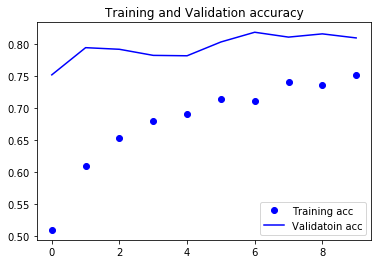

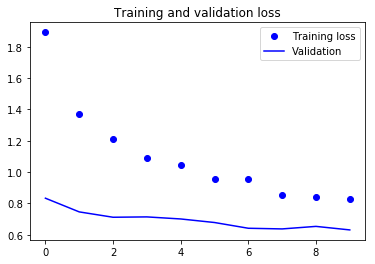

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

N = range(len(acc))
plt.plot(N, acc, 'bo', label='Training acc')
plt.plot(N, val_acc, 'b', label='Validatoin acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(N, loss, 'bo', label='Training loss')
plt.plot(N, val_loss, 'b', label='Validation')
plt.title('Training and validation loss')
plt.legend()

plt.show()
